# ANÁLISIS INICIAL DE LOS DATOS DE UN ACTIVO

Antes de analizar los datos de una cartera de activos, vamos a ver cómo se analizan los datos de un solo activo. Para ello vamos a:

1. Descargar los precios de un activo

2. Visualizar los precios usando diversas gráficas

3. Calcular la rentabilidad diaria
    * Veremos la diferencia entre la rentabilidad simple y la logarítmica
    * Analizaremos si los retornos son ruido blanco (independientes entre sí)


4. Analizaremos el binomio riesgo-rentabilidad
    * Calcularemos la rentabilidad esperada y la volatilidad y las visualizaremos
    * Comprobaremos si las rentabilidades siguen una distribución normal

5. Analizaremos otas medidas del riesgo
    * Calcularemos el VaR y el CVaR
    * Calcularemos el drawdown
    * Usaremos la distribución t-Student para las rentabilidades

In [60]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [126]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import warnings
import requests

import yfinance as yf
import quandl as ql

import nasdaqdatalink
nasdaqdatalink.read_key(filename="credential/nasdaq_key")

import statsmodels.api as sm

from utils import dibuja_covar, dibuja_covar_ax

# print(plt.style.available) #list of available styles
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Ejecutar solo si se quiere cambiar a datos más actuales descargados desde la web

Se baja los datos de yahoo finance de los últimos 10 años.

In [62]:
# # Tickers de empresas con poca correlación: Apple, ETF de bonos americanos, Bitcoin, ETF de oro, Endesa, Tesla
# tickers = ['AAPL', 'IEF', 'BTC-USD', 'IAU','ELE.MC', 'TSLA']  # Ticker of company to be analysed
# data_OHLC_df = yf.download(tickers, period='10y', interval='1d')
# # Lo guardamos en un excel para poder usarlo
# #data_OHLC_df.to_excel('../data/data_OHLC.xlsx')

# # Tickers de empresas con más correlación: Apple, Cisco, IBM, Microsoft, Intel, Oracle
# tickers_corr = ['AAPL', 'CSCO', 'IBM', 'MSFT', 'INTC', 'ORCL']
# data_OHLC_df_corr = yf.download(tickers_corr, period='10y', interval='1d')
# # Lo guardamos en un excel para poder usarlo 
# #data_OHLC_df_corr.to_excel('../data/data_OHLC_corr.xlsx')

Hacemos una gŕafica de velas y de volumen de las acciones de Apple

para eso me bajo los datos OHLC de Apple de los últimos 6 meses

In [63]:
data_df = yf.download('AAPL', period='6mo', interval='1d')

[*********************100%%**********************]  1 of 1 completed


Hacer gráfico sencillo de los precios de cierre de las acciones de Apple

<Axes: title={'center': 'AAPL Stock Price'}, xlabel='Date'>

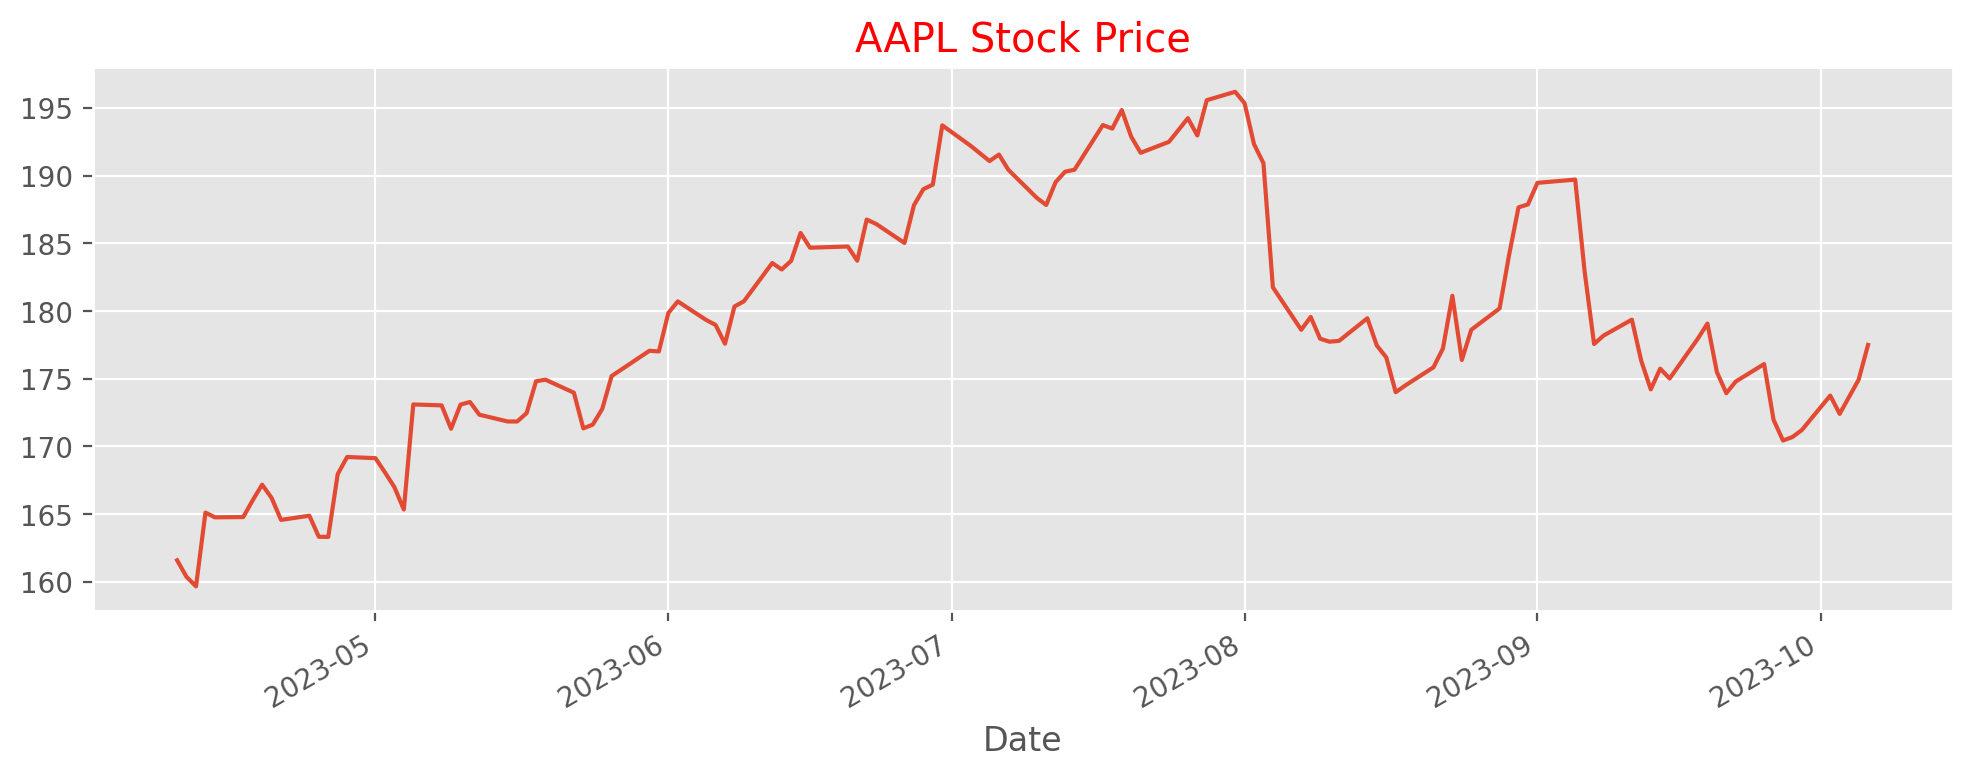

In [64]:
company = 'AAPL'
fig, ax = plt.subplots(figsize=(12, 4))
data_df.loc[:, 'Adj Close'].plot(title=f'{company} Stock Price')

Podemos hacer gráficos de velas usando distintas librerías:

* mplfinance

* plotly que permite hacer gráficos interactivos

In [140]:
company='APPLE'
mpf.plot(data_df, type='candle', volume=True, style='tradingview', figratio=(12, 4), title=f'{company} Stock Price')

TypeError: kwarg "style" validator returned False for value: "ggplot"
    def _valid_mpf_style(value):
    if value in available_styles():
        return True
    if not isinstance(value,dict):
        return False
    if 'marketcolors' not in value:
        return False
    if not isinstance(value['marketcolors'],dict):
        return False
    # {'candle': {'up': 'b', 'down': 'g'},
    #  'edge': {'up': 'k', 'down': 'k'},
    #  'wick': {'up': 'k', 'down': 'k'},
    #  'ohlc': {'up': 'k', 'down': 'k'},
    #  'volume': {'up': '#1f77b4', 'down': '#1f77b4'},
    #  'vcedge': {'up': '#1f77b4', 'down': '#1f77b4'},
    #  'vcdopcod': False,
    #  'alpha': 0.9}
    for item in ('candle','edge','wick','ohlc','volume'):
        if item not in value['marketcolors']:
            return False
        itemcolors = value['marketcolors'][item]
        if not isinstance(itemcolors,dict):
            return False
        if 'up' not in itemcolors or 'down' not in itemcolors:
            return False
    return True

In [141]:
fig = go.Figure(data=[go.Candlestick(x=data_df.index,
                open=data_df['Open'],
                high=data_df['High'],
                low=data_df['Low'],
                close=data_df['Close'])])

fig.update_layout(title = f'{company}: Candlestick Price Chart', xaxis_tickfont_size = 14)
fig.update_layout(xaxis_rangeslider_visible = False)
    
fig.show()

# Binomio rentabilidad-riesgo

La teoría financiera siempre ha caracterizado por:

* Los inversores tienen **aversión al riesgo**

* Los activos los representamos por el **binomio rentabilidad-riesgo**: 
        
  - La **rentabilidad** se mide como la media de los rentornos
    
  - El **riesgo** se mide a través de la volatilidad, que es la desviación estándar de los rendimientos.

Vamos a verlo con algunos datos reales.

### Primero calculamos los retornos

Existen dos formas de convertir precios en rendimientos:

1. Rendimientos aritméticos: $r_t = \frac{P_t}{P_{t-1}} - 1$

2. Rendimientos logarítmicos: $r_t = ln(\frac{P_t}{P_{t-1}})$ 

Los rendimientos aritmeticos se pueden sumar entre activos para obtener el rendimiento de la cartera. Los rendimientos logarítmicos no se pueden sumar.

Los rendimientos logarítmicos se pueden sumar en el tiempo para obtener el rendimiento total. Los rendimientos aritméticos no se pueden sumar.

Los rendimiento aritméticos siguen una distribución lognormal. Los rendimientos logarítmicos siguen una distribución normal.

Ambos rendimientos son equivalentes cuando los rendimientos son pequeños. Veamos como se comportan los rendimientos aritméticos y logarítmicos para distintos valores de rendimiento:

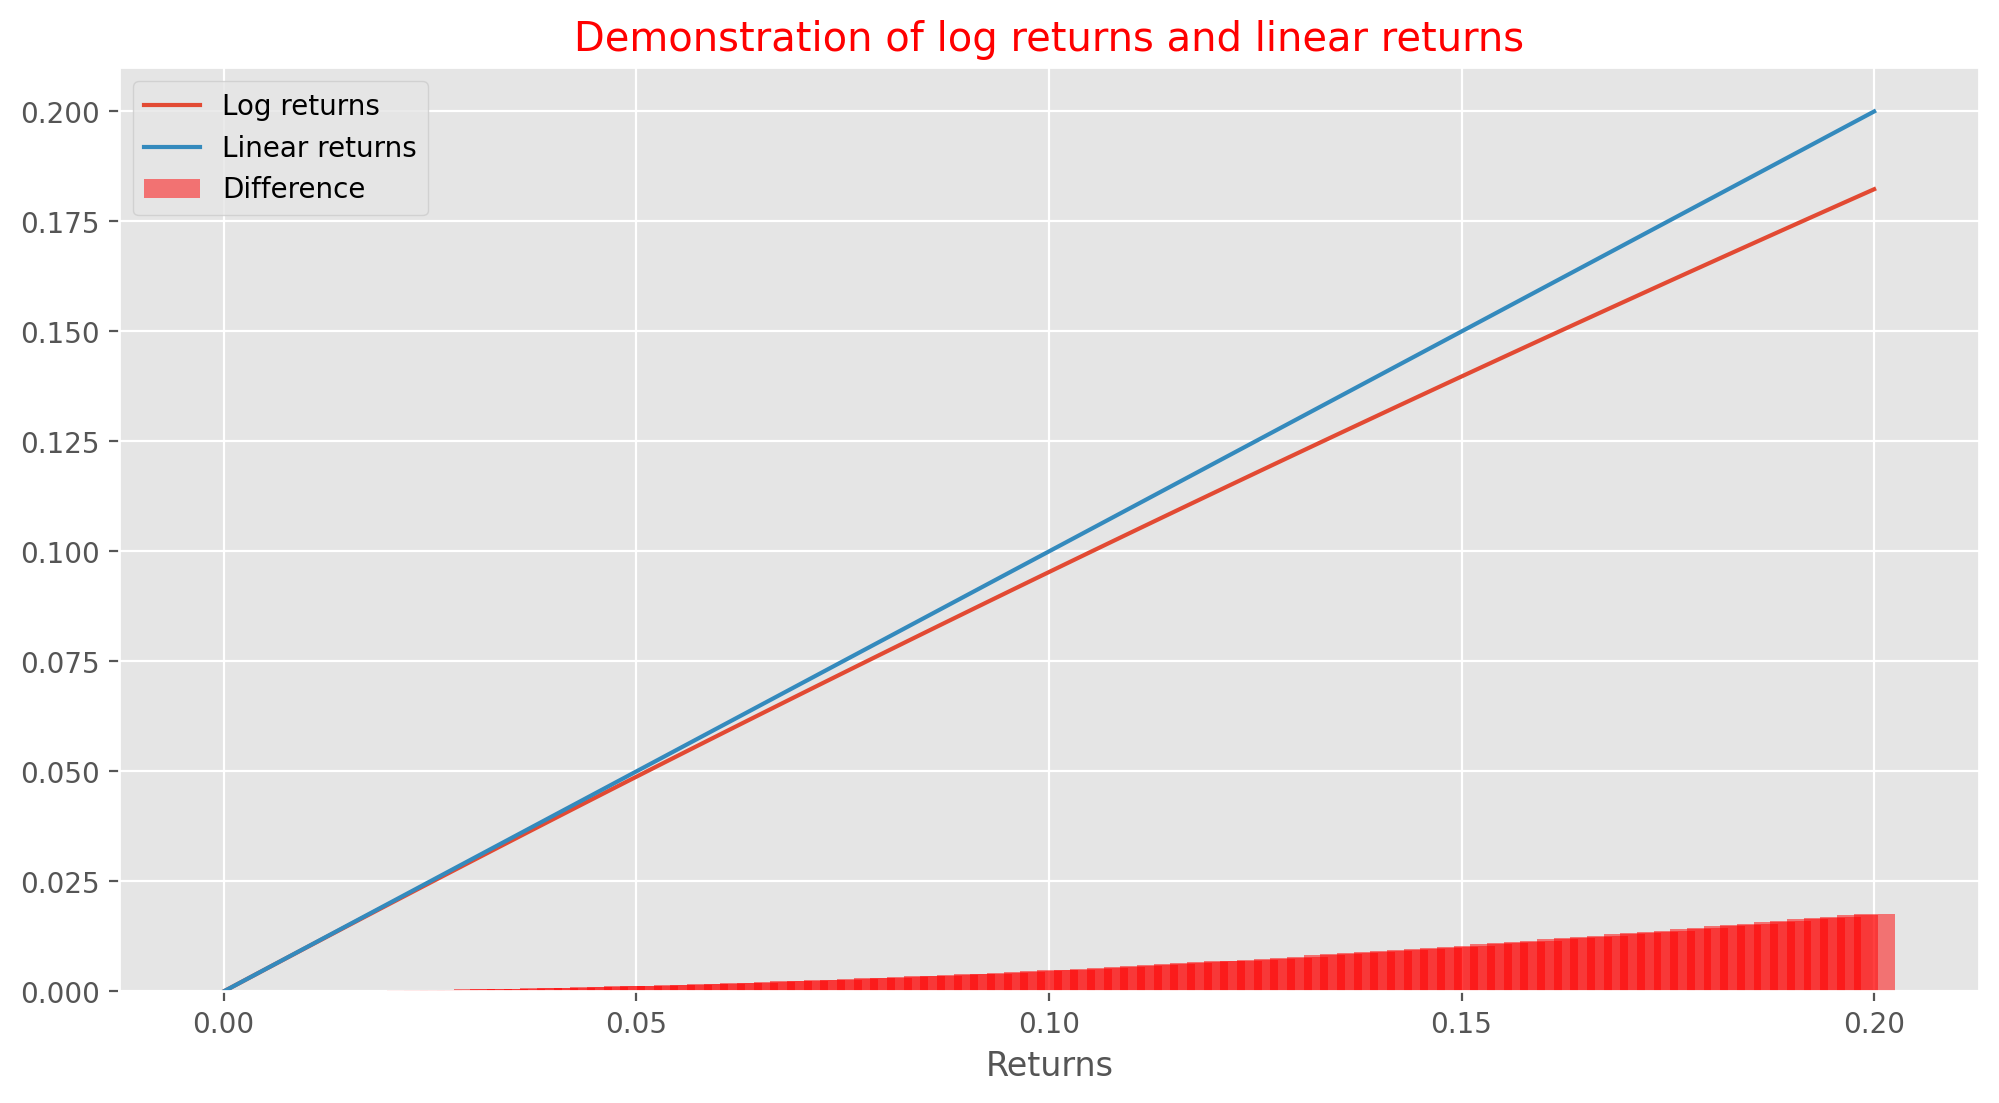

In [142]:
plt.style.use('ggplot')
x_returns = np.linspace(0.0001, .2, 100) # Generate 100 numbers between 0.0001 and 0.2
y_returns = np.log(1 + x_returns) # Calculate the logarithmic returns from the linear returns

# Plot the linear and log returns
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x_returns, y_returns, label='Log returns') # Plot the log returns
plt.plot(x_returns, x_returns, label='Linear returns') # Plot the linear returns
plt.bar(x_returns, x_returns-y_returns, width=0.005, color='r', alpha=0.5, label='Difference', ) # Plot the difference between the two returns
plt.legend()
plt.xlabel('Returns')
plt.title('Demonstration of log returns and linear returns');

Para poder calcular los retornos de activos reales, LEEMOS LOS DATOS DE FICHERO

Nos bajamos dos grupos de activos que nos servirán para analizar distintas cosas más adelante

In [68]:
data_OHLC_df = pd.read_excel('../data/data_OHLC.xlsx', header=[0, 1], index_col=0, parse_dates=True)
data_OHLC_df_corr = pd.read_excel('../data/data_OHLC_corr.xlsx', header=[0, 1], index_col=0, parse_dates=True)

Nos quedamos con los datos de cierre de cada día y calculamos los rendimientos diarios.

In [69]:
data_close_df = data_OHLC_df['Adj Close'].dropna()
ret_close_df = np.log(data_close_df).diff().dropna()

data_close_df_corr = data_OHLC_df_corr['Adj Close'].dropna()
ret_close_df_corr = np.log(data_close_df_corr).diff().dropna()

Calculamos los retornos logarítmicos

In [70]:
ret_df = np.log(data_df.loc[:, 'Adj Close']).diff().dropna()


In [133]:
# Crear una figura interactiva de Plotly
fig = px.line(ret_df, x=ret_df.index.values, y='Adj Close', title='Gráfica de Retornos Diarios')

# Personaliza el diseño de la gráfica
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Retornos',
    template='plotly',  # Puedes elegir un tema de diseño que te guste
    hovermode='x',  # Muestra información al pasar el cursor sobre la gráfica
    showlegend=True  # Muestra la leyenda si tienes varias líneas
)

# Agregar etiquetas a los puntos de datos
fig.update_traces(mode='markers+lines', hovertemplate='%{y:.2f}')

# Mostrar la gráfica interactiva
fig.show()

Verificamos que los retornos son ruido blanco, es decir, que no tienen autocorrelación y son independientes entre sí

Para más información sobre el ruido blaco, pincha [aquí](https://es.wikipedia.org/wiki/Ruido_blanco)

Para ello calculamos la **autocorrelación y la autocorrelación parcial** de los retornos. Si los retornos son ruido blanco, la autocorrelación y la autocorrelación parcial deberían ser cero.

Para más información sobre la autocorrelación y la autocorrelación parcial, pincha [aquí](https://es.wikipedia.org/wiki/Autocorrelaci%C3%B3n)

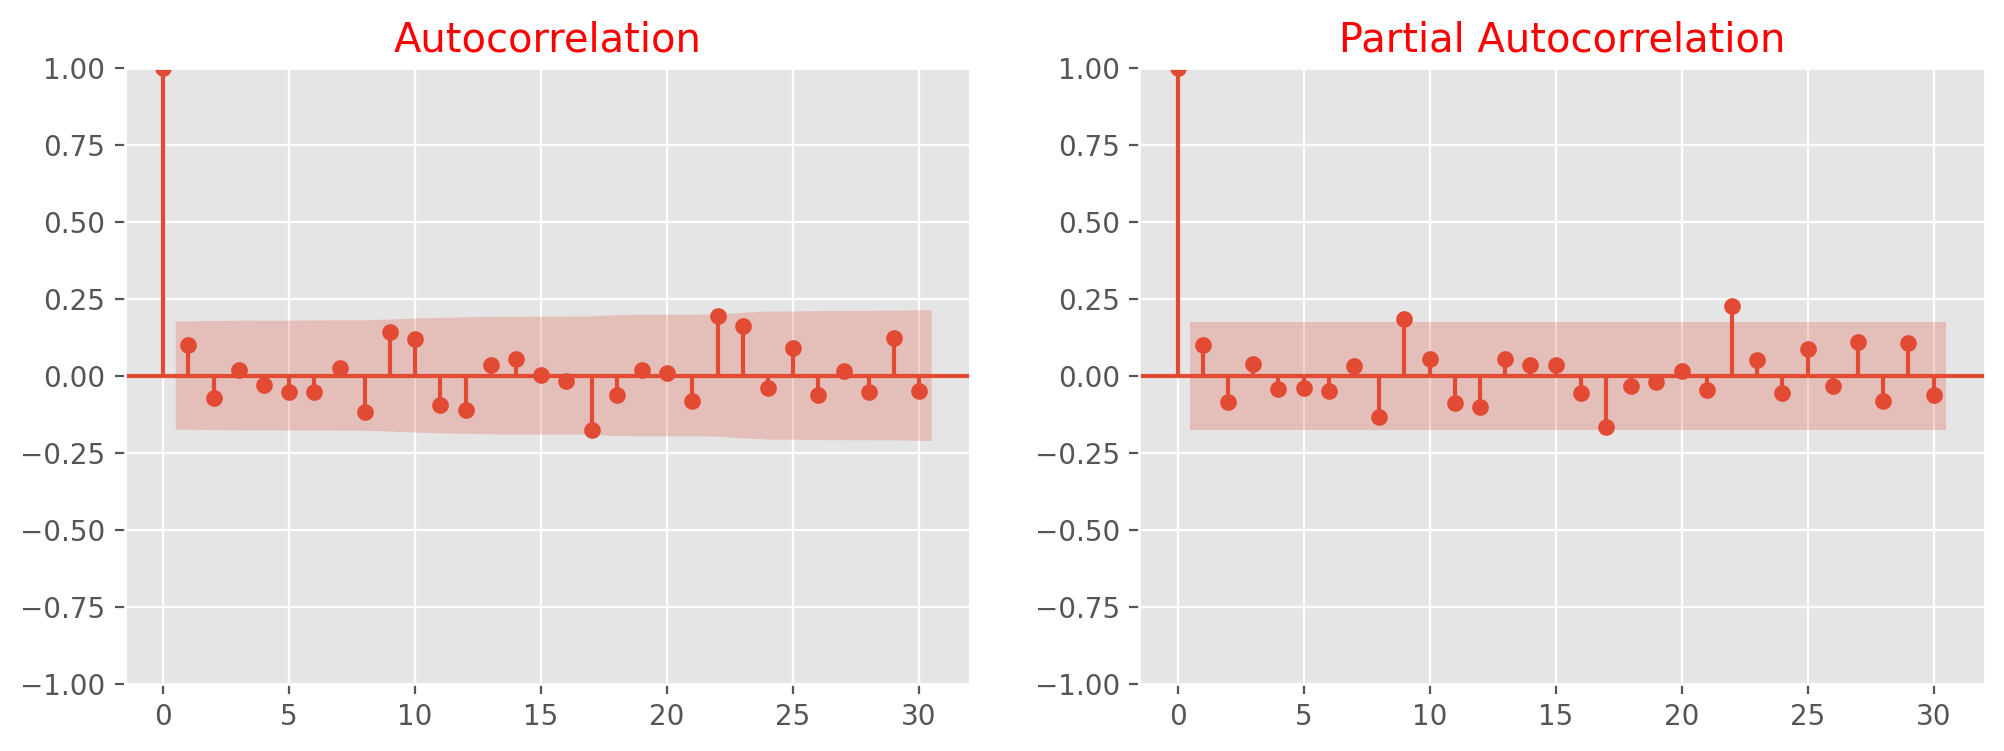

In [143]:
# Calculamos y graficamos PACF y ACF
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(ret_df, lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(ret_df, lags=30, ax=ax[1])
plt.show()



Hacemos unas gráficas para ver la rentabilidad y volatilidad de cada activo

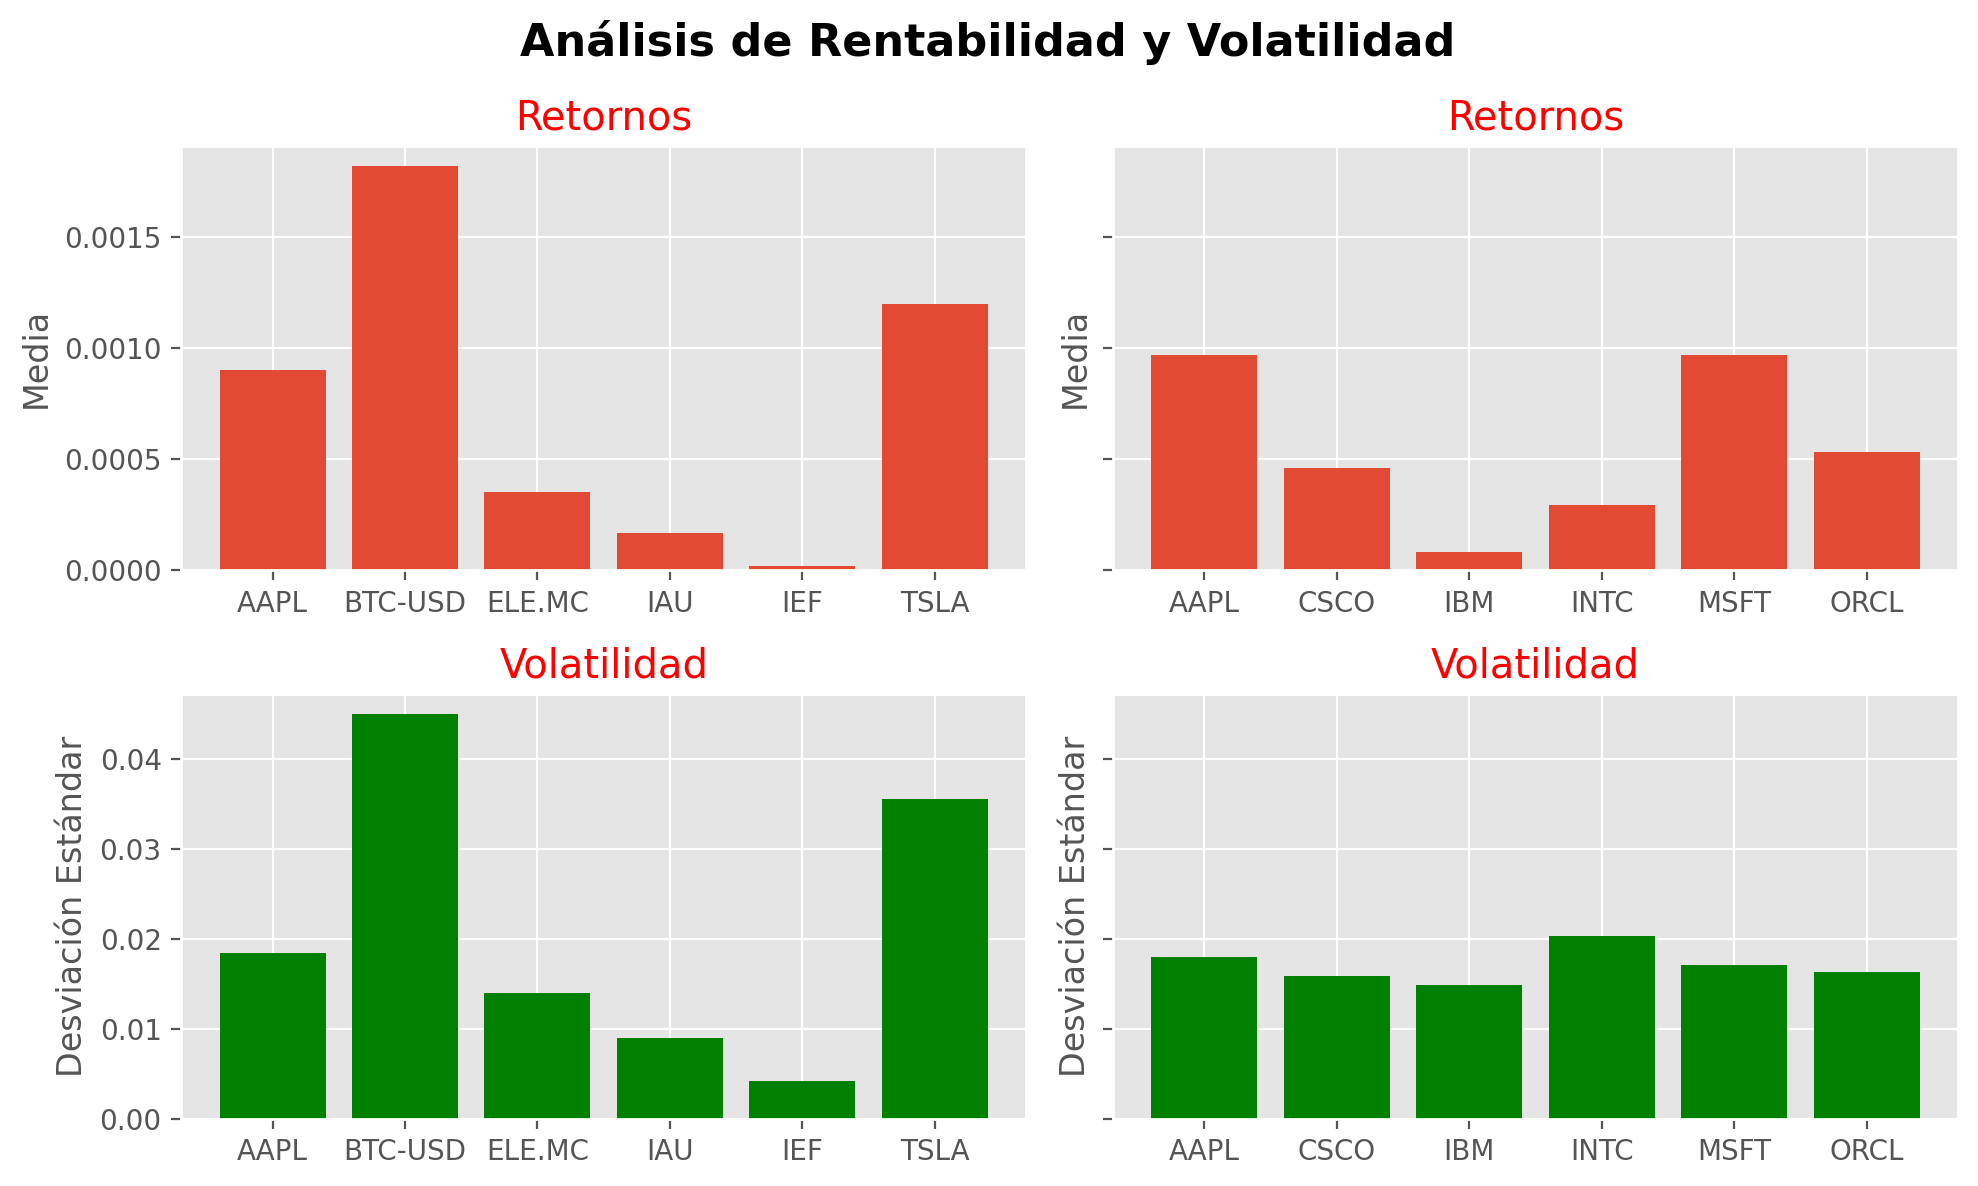

In [131]:
# Puedes calcular los valores medios y la desviación estándar de cada columna así:
means = ret_close_df.mean()
stds = ret_close_df.std()
means_corr = ret_close_df_corr.mean()
stds_corr = ret_close_df_corr.std()

# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0, 0].bar(means.index, means.values)
axes[0, 0].set_ylabel('Media')
axes[0, 0].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 0].bar(stds.index, stds.values,color='green')
axes[1, 0].set_ylabel('Desviación Estándar')
axes[1, 0].set_title('Volatilidad')

#Crear una figura con dos subplots, uno encima del otro
axes[0, 1].bar(means_corr.index, means_corr.values)
axes[0, 1].set_ylabel('Media')
axes[0, 1].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 1].bar(stds_corr.index, stds_corr.values,color='green')
axes[1, 1].set_ylabel('Desviación Estándar')
axes[1, 1].set_title('Volatilidad')

# Añadir un título general a la figura
plt.suptitle('Análisis de Rentabilidad y Volatilidad', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

También podemos verlo usando las gráficas de distribución de los retornos diarios de cada activo.

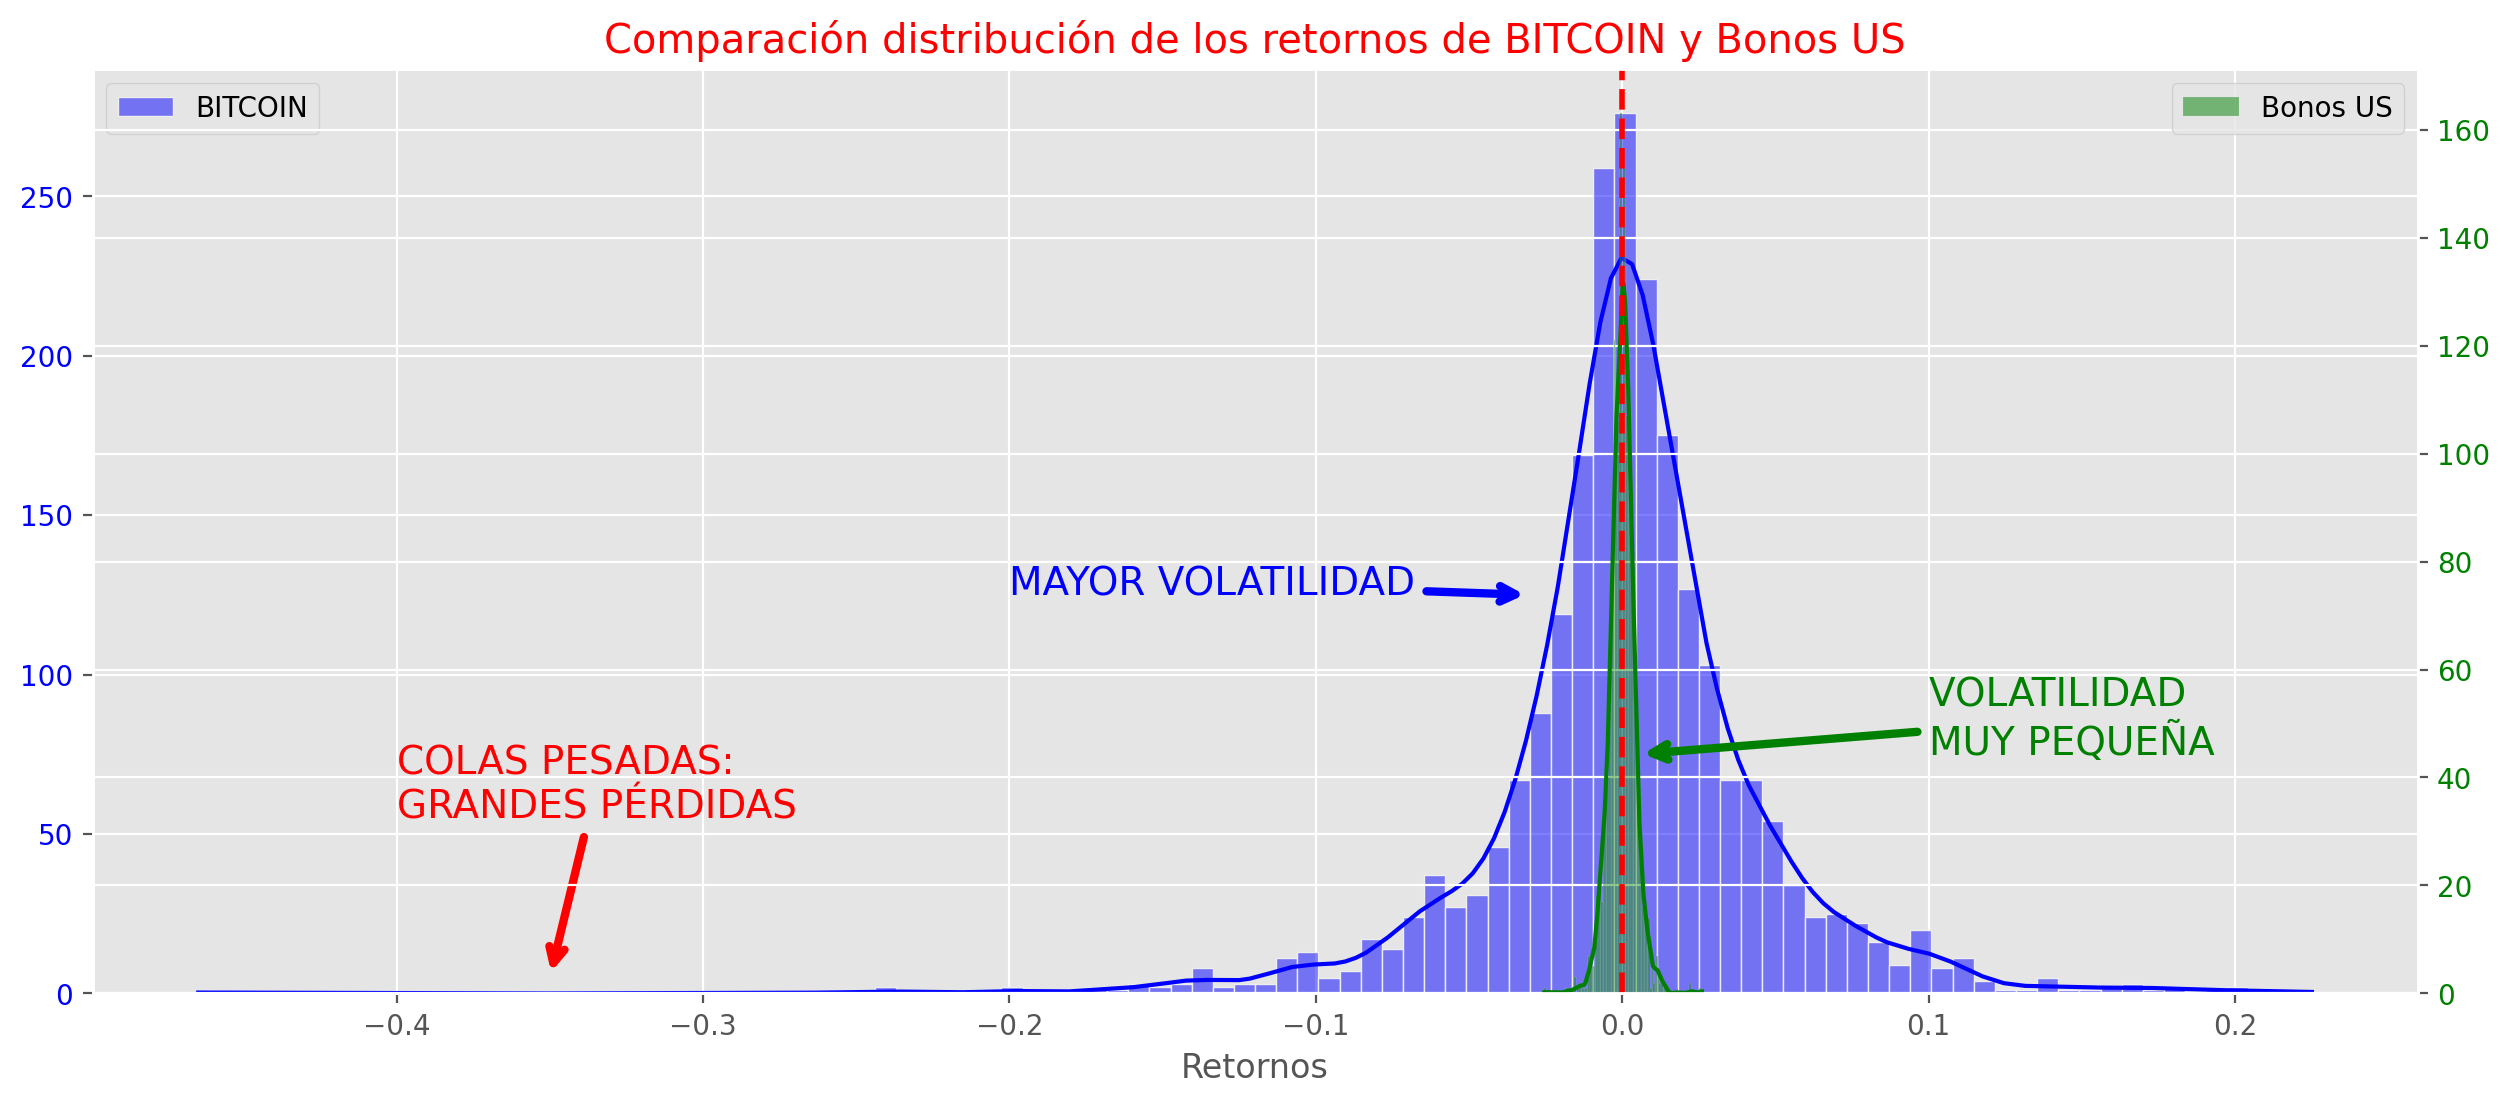

In [130]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Crear el primer gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='BTC-USD', ax=ax1, bins=100, color='blue', kde=True, alpha=0.5, label='BITCOIN')
ax1.set_xlabel('Retornos')
ax1.set_ylabel('', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# # Añadir texto en ax2
# text_x = -0.4
# text_y = 25

#ax1.text(-0.2, 125, f"MAYOR VOLATILIDAD", fontsize=12, color='blue')

ax1.annotate('MAYOR VOLATILIDAD', xy=(-0.03, 125), xytext=(-0.2, 125),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='blue'),
            fontsize=14, color='blue')

ax1.annotate('VOLATILIDAD \nMUY PEQUEÑA', xy=(0.005, 75), xytext=(0.1, 75),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='green'),
            fontsize=14, color='green')

ax1.annotate('COLAS PESADAS: \nGRANDES PÉRDIDAS', xy=(-0.35, 5), xytext=(-0.4, 55),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')



# Duplicar el eje Y para el segundo gráfico
ax2 = ax1.twinx()

# Crear el segundo gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='IEF', ax=ax2, bins=100, color='green', kde=True, alpha=0.5, label='Bonos US')
ax2.set_ylabel('', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Añadir una línea vertical en el eje X en 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
# Configurar título y mostrar el gráfico
plt.title('Comparación distribución de los retornos de BITCOIN y Bonos US')
plt.show()

Para poder analizar el comportamiento de un activo necesitamos la distribución de los retornos, pero en general se emplea solo la rentabilidad y el riesgo.

La teoría de que los activos se pueden caracterizar por el binomio rentabilidad-riesgo se cumple si:

* La función de utilidad del inversor es cuadrática. Fuera del scope de este curso.

* Los **retornos siguen una distribución normal**: Una normal se caracteriza por media y varianza.  

Vamos a comprobar si los retornos siguen una normal. 

Para comprobarlo vamos a usar los retornos del Bitcoin y los vamos a comparar con una distribución normal (con la misma media y desviación estándar)
     

Generamos unos datos sintéticos con distribución normal, media y desviación igual a la de los retornos del Bitcoin

In [75]:
# Definir la media y la desviación estándar
media = ret_close_df['BTC-USD'].mean()
std = ret_close_df['BTC-USD'].std()

# Establecer la semilla (seed)
np.random.seed(3)  # Puedes usar cualquier número como semilla

# Generar una serie de números con distribución normal
data_norm = np.random.normal(media, std, 100000)  # 100000 números aleatorios

Como primera manera de analizar si los retornos siguen una distribución normal, usaremos los gráficos QQ-Plot.

Si los puntos se ajustan a la recta, los datos siguen una distribución normal.

Para más información sobre QQ-Plot pinchar [aquí](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

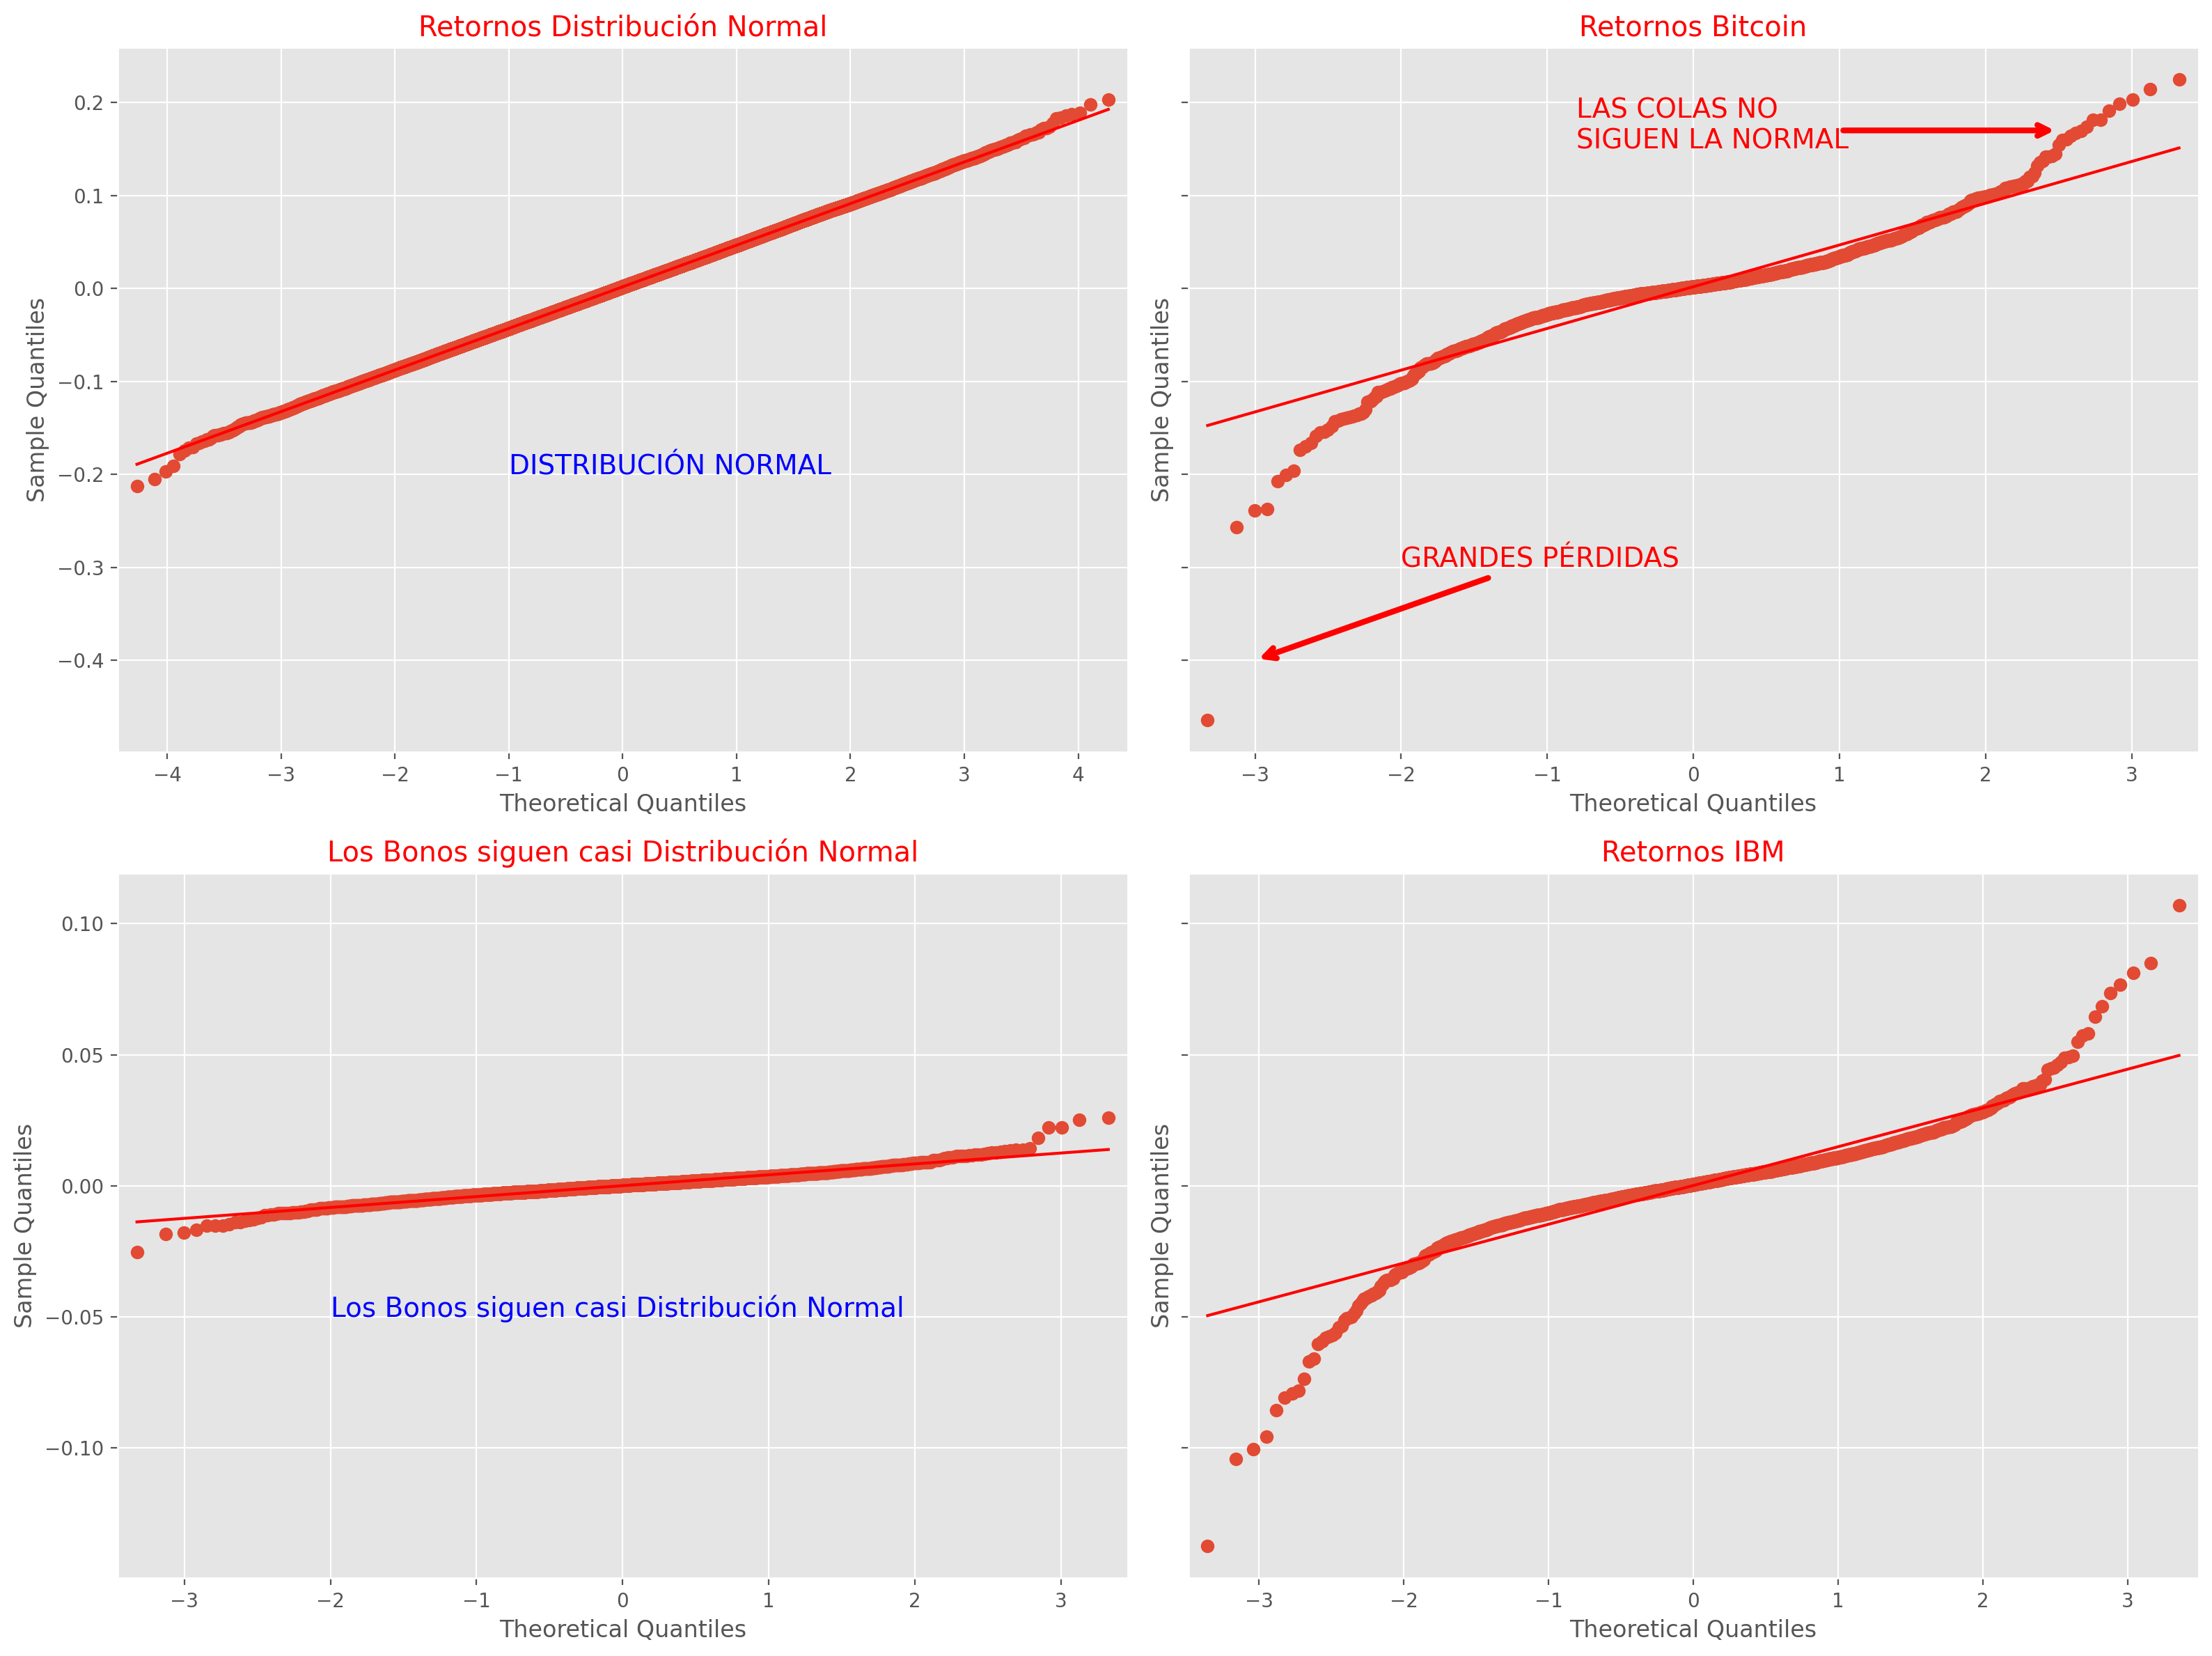

In [129]:

# Crear una figura con dos subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharey='row')

# Graficar el primer histograma en el primer subplot
sm.qqplot(data_norm, line='s', ax=axs[0,0])
axs[0,0].set_title('Retornos Distribución Normal')

axs[0,0].text(-1, -0.2, "DISTRIBUCIÓN NORMAL", fontsize=14, color='blue')

# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df['BTC-USD'], line='s', ax=axs[0,1])
axs[0,1].set_title('Retornos Bitcoin')

# Añadir texto en ax2
text_x = -3
text_y = -0.35

#axs[0,1].text(text_x, text_y, "GRANDES PÉRDIDAS", fontsize=14, color='RED')

text_x = -1.5
text_y = 0.15

axs[0,1].text(-0.8, 0.15, "LAS COLAS NO \nSIGUEN LA NORMAL", fontsize=14, color='RED')

axs[0,1].annotate("", xy=(2.5, 0.17), xytext=(1, 0.17),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')


# Dibuja una flecha utilizando annotate
axs[0,1].annotate('GRANDES PÉRDIDAS', xy=(-3, -0.4), xytext=(-2, -0.3),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')


# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df['IEF'], line='s', ax=axs[1,0])
axs[1,0].set_title('Retornos Bonos US')
axs[1,0].set_title('Los Bonos siguen casi Distribución Normal')
axs[1,0].text(-2, -0.05, "Los Bonos siguen casi Distribución Normal", fontsize=14, color='blue')

# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df_corr['IBM'], line='s', ax=axs[1,1])
axs[1,1].set_title('Retornos IBM')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

Existen varios tests para comprobar si los datos siguen una distribución normal. Los más conocidos son el test de [Kolmogorov-Smirnov](https://es.wikipedia.org/wiki/Prueba_de_Kolmog%C3%B3rov-Smirnov) y el test de [Shapiro-Wilk](https://es.wikipedia.org/wiki/Prueba_de_Shapiro%E2%80%93Wilk).

In [77]:
# Prueba de Kolmogorov-Smirnov
stat, p = stats.kstest(ret_close_df['BTC-USD'], 'norm')

# Compara el valor p con un nivel de significancia (por ejemplo, 0.05)
alpha = 0.05
if p > alpha:
    print(f"El resultado es de {p:.4f}, lo que quiere decir que los datos SÍ SIGUEN una distribución normal (no podemos rechazar la hipótesis nula)")
else:
    print(f"El resultado es de {p:.4f}, lo que quiere decir que los datos NO SIGUEN una distribución normal (rechazamos la hipótesis nula)")

El resultado es de 0.0000, lo que quiere decir que los datos NO SIGUEN una distribución normal (rechazamos la hipótesis nula)


**CONCLUSIÓN: LOS RETORNOS NO SIGUEN UNA DISTRIBUCIÓN NORMAL**

* Las colas de la distribución de los retornos son más pesadas que las de una distribución normal.

* Esto quiere decir que hay más probabilidad de que ocurran eventos extremos (tanto positivos como negativos) de lo que cabría esperar si los retornos siguieran una distribución normal.

* Por lo general, la cola izquierda es más pesada que la derecha, lo que quiere decir que hay más probabilidad de que ocurran eventos negativos extremos que positivos extremos.

**CONSECUENCIA: EL BINOMIO RENTABILIDAD-RIESGO NO ES SUFICIENTE PARA CARACTERIZAR LOS ACTIVOS**

Necesitamos más información para caracterizar los activos. Necesitamos conceptos como:

* Asimetría y curtosis

* VaR

* CVaR

* Drawdown

* Usar otras distribuciones de probabilidad (t-student, ...)

### Asimetría o skewness

El skewness de los retornos de una acción es una medida de la asimetría de la distribución de los retornos de esa acción. 

La interpretación del skewness de los retornos de una acción es la siguiente:

* Un skewness positivo indica que la acción tiene una mayor probabilidad de generar ganancias que pérdidas.

* Un skewness negativo indica que la acción tiene una mayor probabilidad de generar pérdidas que ganancias.

* Un skewness neutro indica que la acción tiene una probabilidad igual de generar ganancias que pérdidas.

<center>
    <img src="../imgs/skewness.PNG"  alt="drawing" width="500">
</center>

Analicemos el skewness de los retornos de los activos que tenemos.

Si los retornos siguieran una distribución normal, el skewness debería ser 0.

In [78]:
df_skew = ret_close_df.skew()
df_corr_skew = ret_close_df_corr.skew()

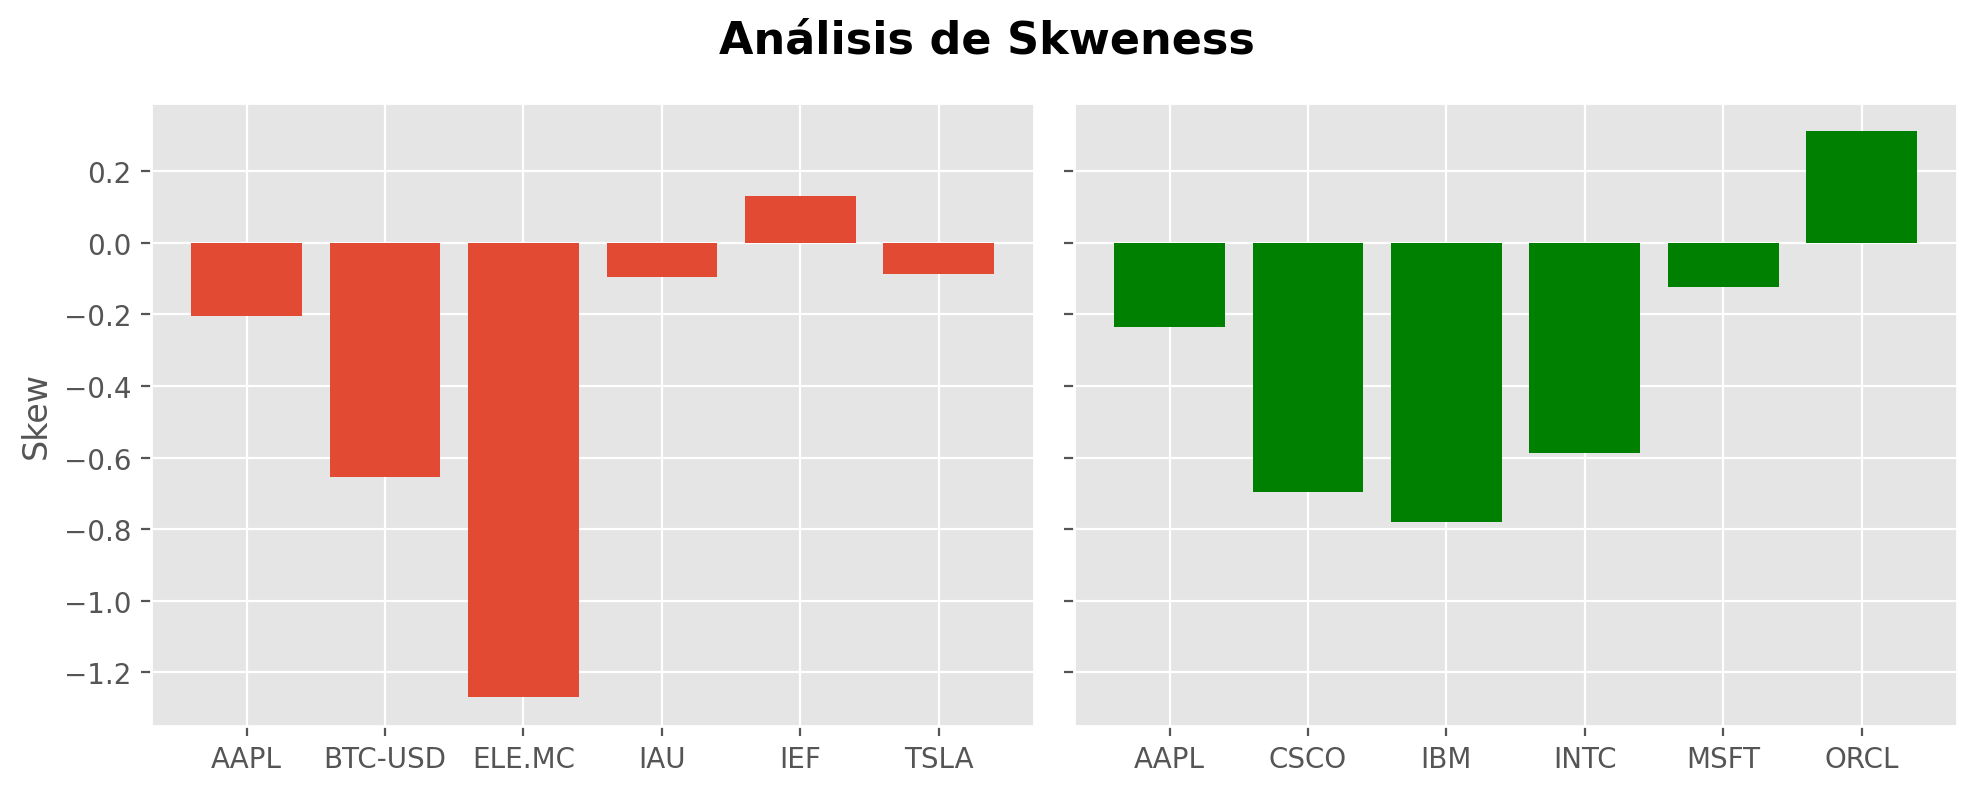

In [128]:
# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0].bar(df_skew.index.values, df_skew.values)
axes[0].set_ylabel('Skew')
axes[0].set_title('')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1].bar(df_corr_skew.index.values, df_corr_skew.values ,color='green')
axes[1].set_ylabel('')
axes[1].set_title('')


# Añadir un título general a la figura
plt.suptitle('Análisis de Skweness', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Curtosis o kurtosis

La curtosis es una medida de la forma de la distribución de los retornos de una acción. 

Se puede pensar en la curtosis como una medida de la "punta" de la distribución. Una distribución con curtosis alta tiene una "punta" más pronunciada que la distribución normal

La interpretación de la curtosis de los retornos de una acción es la siguiente:

* Una curtosis **igual a 3** indica que os retornos siguen una **distribución normal**.

* Una curtosis **mayor que 3** indica que la acción tiene una **mayor probabilidad de generar retornos extremos**, ya sean positivos o negativos.

* Una curtosis **menor que 3** indica que la acción tiene una **menor probabilidad de generar retornos extremos**.

In [80]:
df_curto = ret_close_df.kurtosis()
df_corr_curto = ret_close_df_corr.kurtosis()

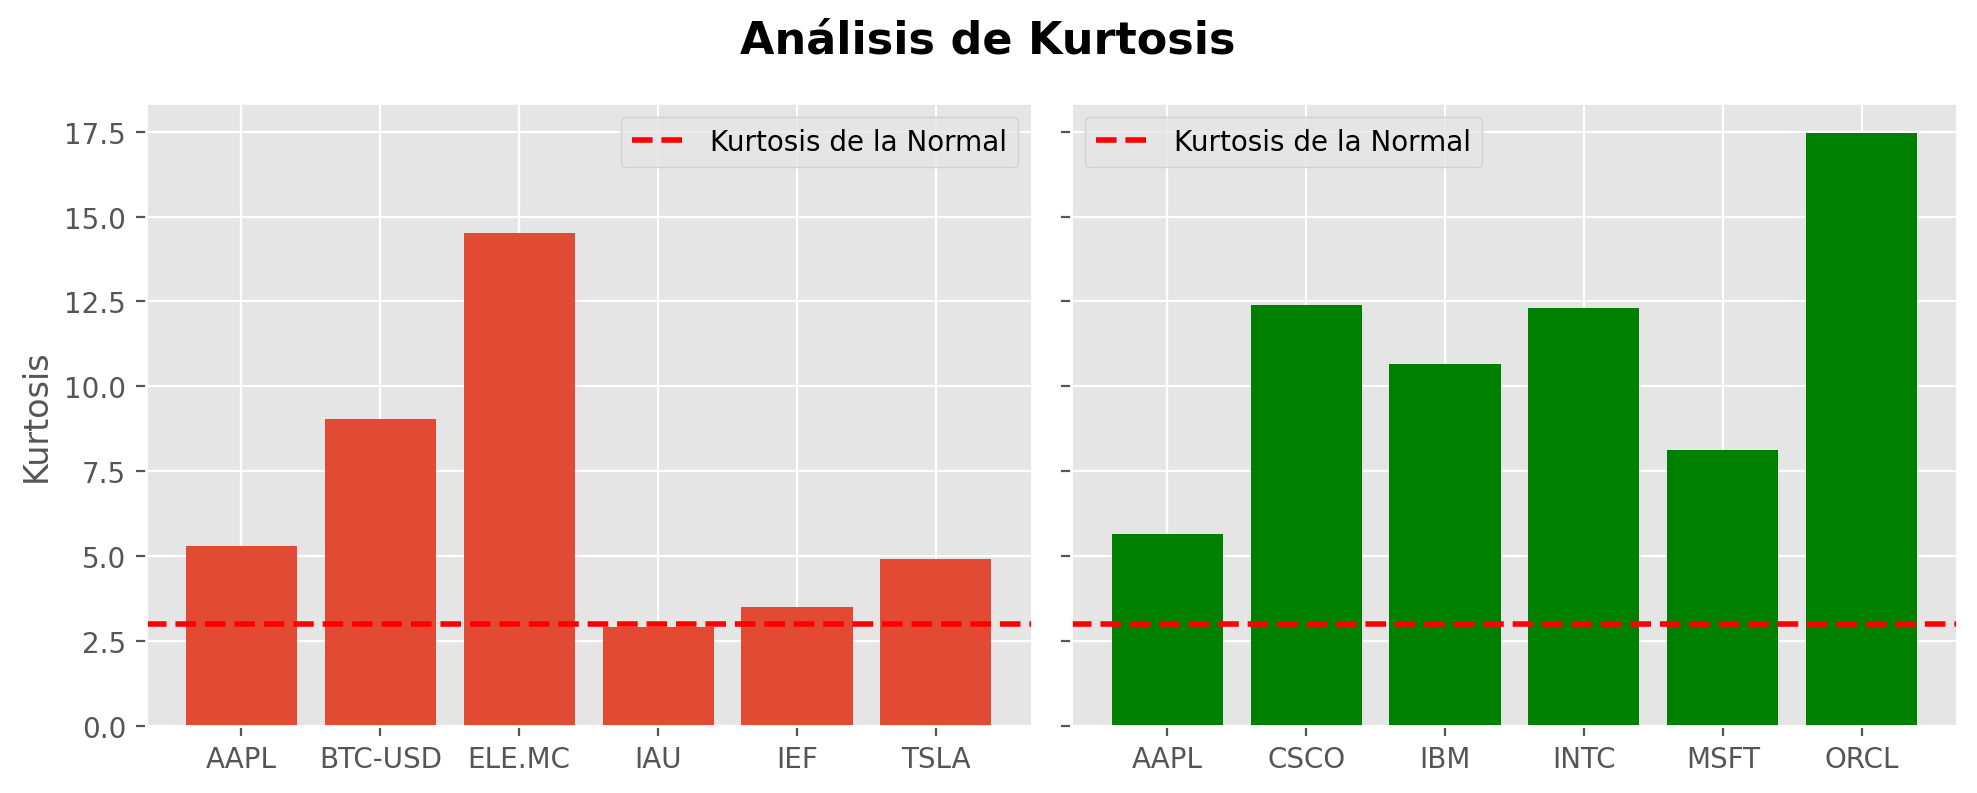

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='row')
axes[0].bar(df_curto.index.values, df_curto.values)
axes[0].set_ylabel('Kurtosis')
axes[0].set_title('')
axes[1].bar(df_corr_curto.index.values, df_corr_curto.values ,color='green')
axes[1].set_ylabel('')
axes[1].set_title('')
axes[0].axhline(y=3, color='red', linestyle='--', linewidth=2, label='Kurtosis de la Normal')
axes[0].legend(loc='upper right')

axes[1].axhline(y=3, color='red', linestyle='--', linewidth=2, label='Kurtosis de la Normal')
axes[1].legend(loc='upper left')
plt.suptitle('Análisis de Kurtosis', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

Veamos el impacto de la curtosis en la distribución de los retornos.

Recordad que valores altos de curtosis indican probabilidad de retornos extremos, por lo general grandes pérdidas.

Vamos a graficar la distribución de los retornos de un activo con un valor alto de curtosis y otro con un valor bajo de curtosis.

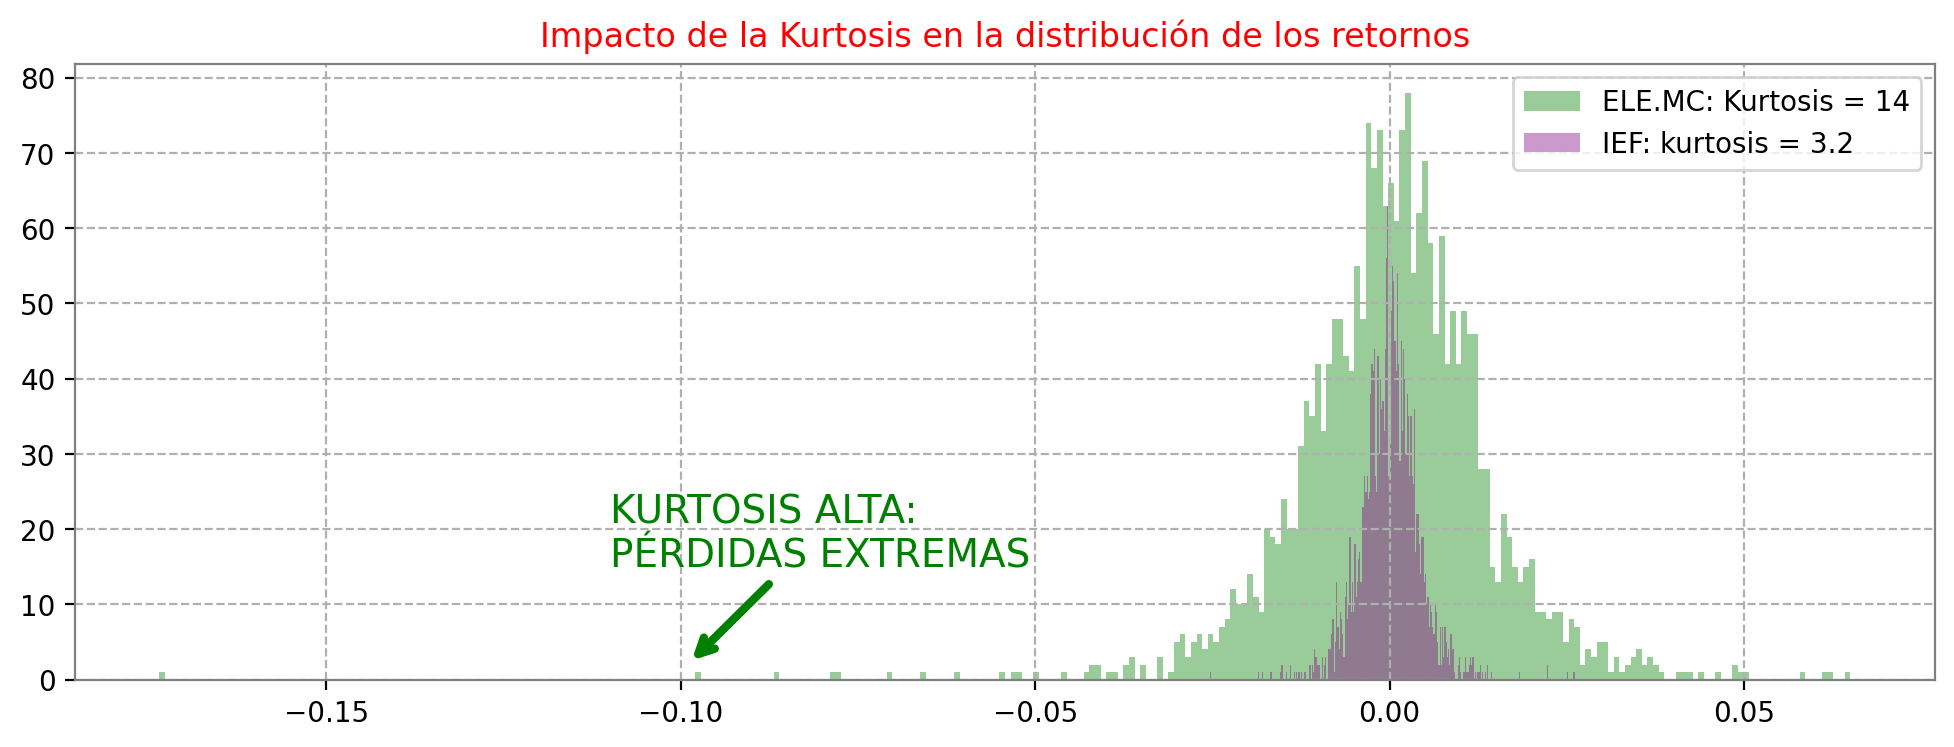

In [82]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.hist(ret_close_df['ELE.MC'], bins=300, color='green', alpha=0.4, label='ELE.MC: Kurtosis = 14')
#plt.hist(ret_close_df_corr['ORCL'], bins=300, color='green', alpha=0.4, label='ORCL')
plt.hist(ret_close_df['IEF'], bins=300, color='purple', alpha=0.4, label='IEF: kurtosis = 3.2')

# Dibuja una flecha utilizando annotate
ax.annotate('KURTOSIS ALTA:\nPÉRDIDAS EXTREMAS', xy=(-0.099, 2), xytext=(-0.11, 15),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='green'),
            fontsize=14, color='green')

plt.title('Impacto de la Kurtosis en la distribución de los retornos')
plt.legend()
plt.show()  

---

### VaR

El Valor en Riesgo (VaR) es una medida del riesgo de mercado de un activo o una cartera de activos.

Se define como la pérdida máxima que se espera que un activo o una cartera de activos sufra en un período de tiempo determinado con un cierto nivel de confianza.

Por ejemplo, si el VaR de una acción es de 100 de euros con un nivel de confianza del 95%, esto significa que hay un 95% de probabilidad de que la acción pierda menos de 100 euros en un período de tiempo determinado.

Para calcular el VaR existen tres métodos:

* Método paramétrico: Se asume que los retornos siguen una distribución normal.

* Método no paramétrico: Se calcula el VaR directamente a partir de los datos históricos.

* Método de simulación: Se simulan los retornos de la acción y se calcula el VaR a partir de los retornos simulados.

Primero vamos a ver el efecto en un activo cuyos distribución de los retornos se parece a una normal y luego en dos activos cuyas distribuciónes de los retornos no se parecen a una normal. 

Para ello, seguimos los siguientes pasos:

1. Calculamos los parámetros de la distribución de los retornos de cada activo: media y desviación estándar.

2. Calculamos el VaR de cada activo usando el método paramétrico y el método no paramétrico.

3. Graficamos la distribución de los retornos de cada activo y el VaR calculado.

In [83]:
# 1. Calcula la media y la desviación estándar de los retornos de cada activo
mu_elec = ret_close_df['ELE.MC'].mean()
sigma_elec = ret_close_df['ELE.MC'].std()
mu_ief = ret_close_df['IEF'].mean()
sigma_ief = ret_close_df['IEF'].std()
mu_btc = ret_close_df['BTC-USD'].mean()
sigma_btc = ret_close_df['BTC-USD'].std()

In [84]:
# 2. Calcula el Var param´etrico y el Var histórico para un nivel de confianza del 95%
confianza = 0.95

# Calcular el VaR usando el método de la distribución normal
varn_95_ele = stats.norm.ppf(1 - confianza, mu_elec, sigma_elec)
varn_95_ief = stats.norm.ppf(1 - confianza, mu_ief, sigma_ief)
varn_95_btc = stats.norm.ppf(1 - confianza, mu_btc, sigma_btc)

# Calcular el VaR usando el método histórico
var_95_ele = np.percentile(ret_close_df['ELE.MC'], 1 - confianza)
var_95_ief = np.percentile(ret_close_df['IEF'], 1 - confianza)
var_95_btc = np.percentile(ret_close_df['BTC-USD'], 1 - confianza)

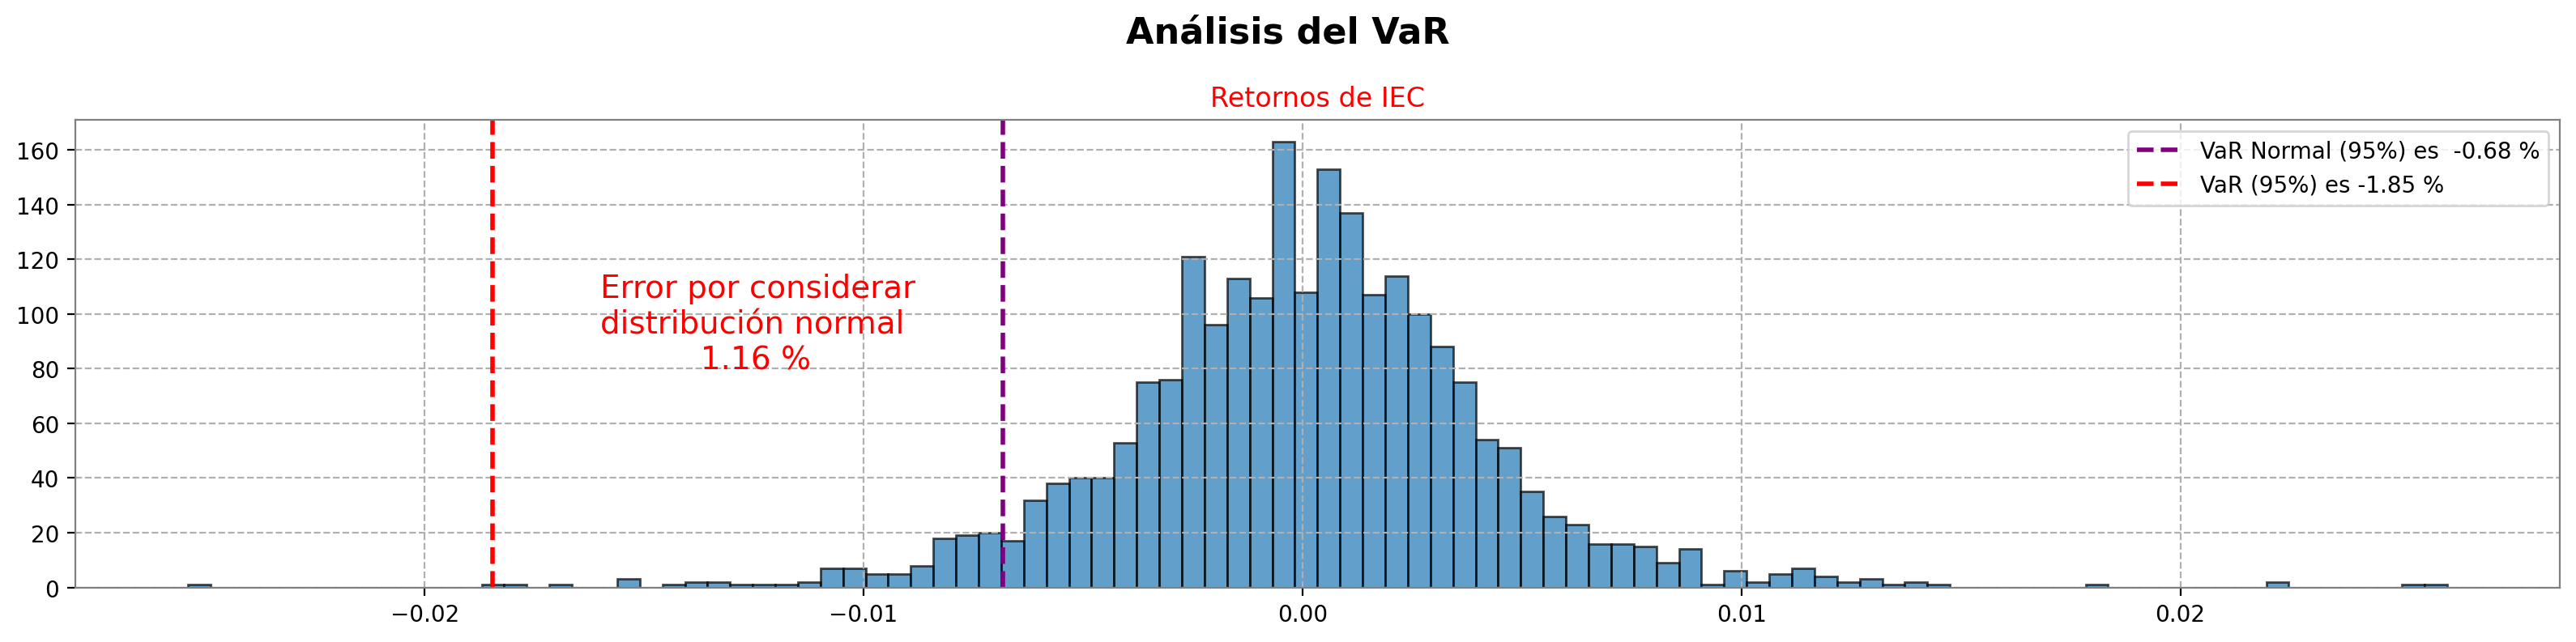

In [85]:
# 3. Hacemos la gráfica para un activo cua distribución de los retornos se parece a la normal IEF - Bonos US

fig, ax = plt.subplots(figsize=(16, 4))


ax.hist(ret_close_df['IEF'], bins=100, edgecolor='black', alpha=0.7)

ax.axvline(x=varn_95_ief, color='purple', linestyle='--', linewidth=2, label=f'VaR Normal (95%) es  {100 * varn_95_ief:.2f} %')
ax.axvline(x=var_95_ief, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_ief:.2f} %')
ax.text(-0.016, 80, f"Error por considerar\ndistribución normal\n          {100 * np.abs(var_95_ief-varn_95_ief):.2f} %", fontsize=14, color='RED')

ax.set_ylabel('')
ax.set_title('Retornos de IEC')
ax.legend()


plt.suptitle('Análisis del VaR', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

INTERPRETACIÓN DE LA GRÁFICA:

1- El **Var Normal** es el VaR calculado usando el método paramétrico, es decir, asumiendo que los retornos siguen una distribución normal.

*  Var Normal nos dice que hay un 95% de probabilidad de que la acción pierda menos del 0.68% en un día.

2- El **Var Histórico** es el VaR calculado usando el método no paramétrico, es decir, usando los datos históricos.

* Var Histórico nos dice que hay un 95% de probabilidad de que la acción pierda menos del 1.85% en un día.

Es decir, cometemos un **error al calcular el riesgo del 1.16%** al asumir que los retornos siguen una distribución normal.

Pero, ¿qué ocurre si usamos activos cuyas distribuciones de los retornos no se parecen a una normal?

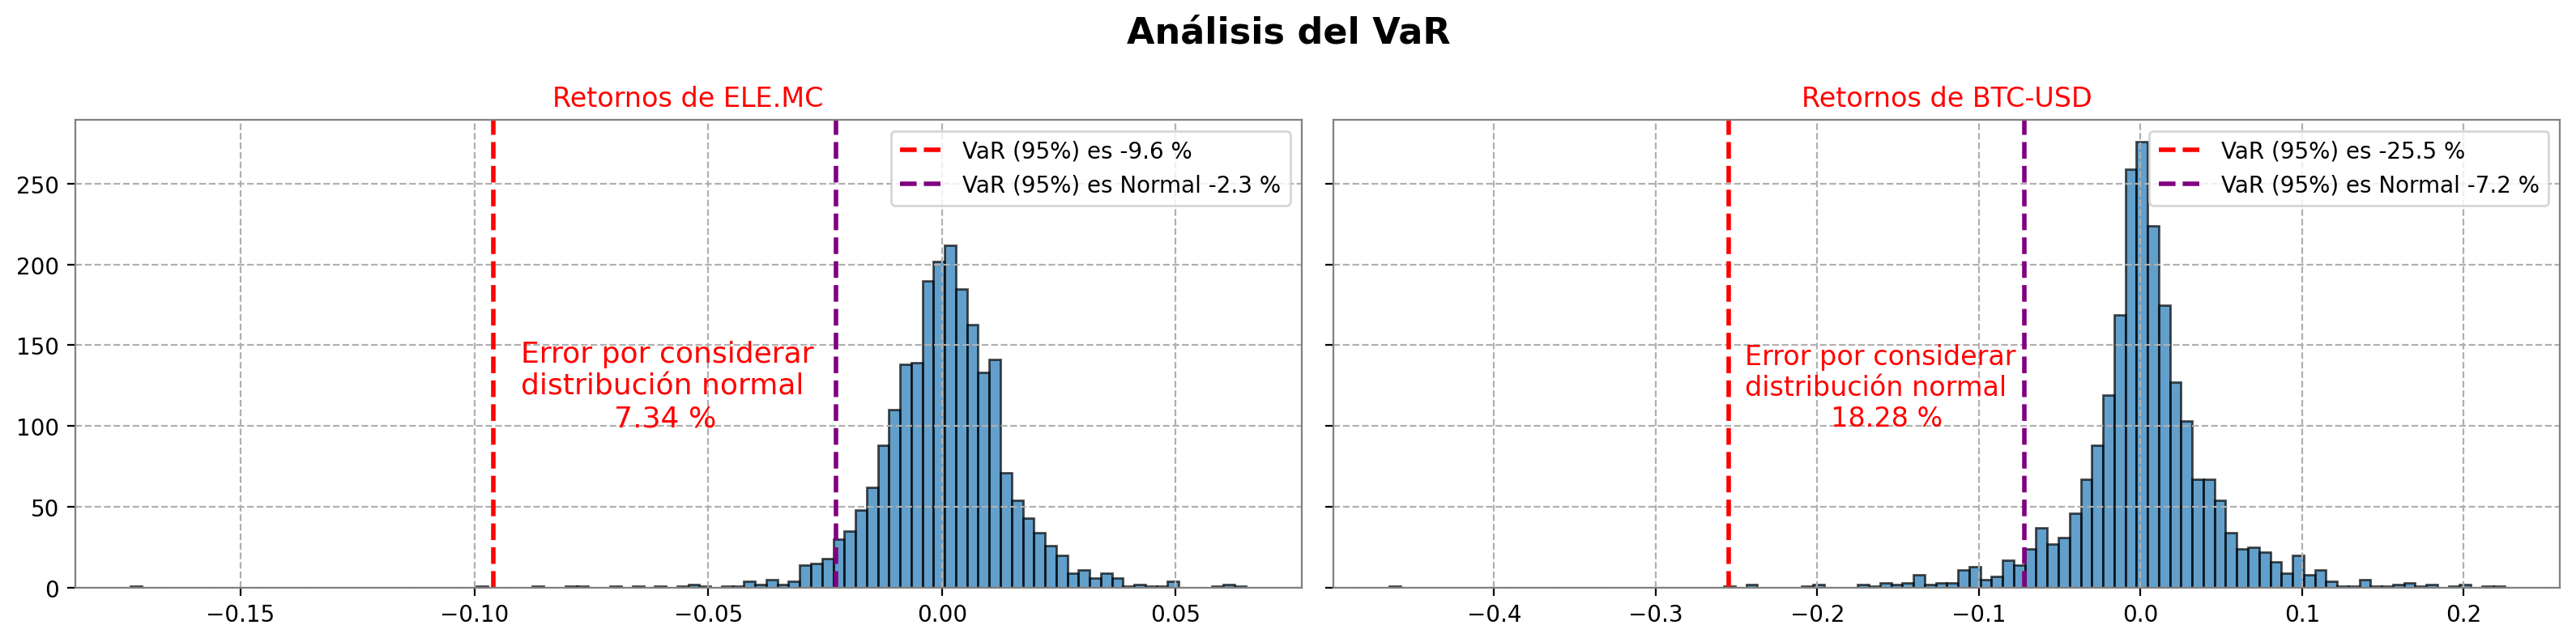

In [86]:
# 3. Hacemos la gráfica para dos activos cuyas distribuciones de los retornos NO se parece a la normal ELE-MC y BTC-USD

fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey='row')
axes[0].hist(ret_close_df['ELE.MC'], bins=100, edgecolor='black', alpha=0.7)
#axes[0].axvline(x=var1_90, color='green', linestyle='--', linewidth=2, label=f'VaR (90%) es {100 * var1_90:.1f} %')
axes[0].axvline(x=var_95_ele, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_ele:.1f} %')
axes[0].axvline(x=varn_95_ele, color='purple', linestyle='--', linewidth=2, label=f'VaR (95%) es Normal {100 * varn_95_ele:.1f} %')
axes[0].text(-0.09, 100, f"Error por considerar\ndistribución normal\n          {100 *np.abs(var_95_ele-varn_95_ele):.2f} %", fontsize=13, color='RED')

axes[0].set_ylabel('')
axes[0].set_title('Retornos de ELE.MC')
axes[0].legend()

axes[1].hist(ret_close_df['BTC-USD'], bins=100, edgecolor='black', alpha=0.7)
#axes[1].axvline(x=var2_90, color='green', linestyle='--', linewidth=2, label=f'VaR (90%) es {100 * var2_90:.1f} %')
axes[1].axvline(x=var_95_btc, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_btc:.1f} %')
axes[1].axvline(x=varn_95_btc, color='purple', linestyle='--', linewidth=2, label=f'VaR (95%) es Normal {100 * varn_95_btc:.1f} %')
axes[1].text(-0.245, 100, f"Error por considerar\ndistribución normal\n          {100 *np.abs(var_95_btc-varn_95_btc):.2f} %", fontsize=12, color='RED')

axes[1].set_ylabel('')
axes[1].set_title('Retornos de BTC-USD')
axes[1].legend()


plt.suptitle('Análisis del VaR', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

### CVaR

+ El VaR tiene un problema: no considera cómo son los retornos que están por debajo del VaR. Es decir, dos activos pueden tener el mismo VaR pero uno puede tener retornos muy negativos y el otro no.

+ Para solucionar este problema se usa el CVaR o Conditional Value at Risk. El CVaR es la **media de los retornos que están por debajo del VaR**.

In [87]:
# Calcular el CVAR al 95%
cvar_95_ele = np.mean(ret_close_df['ELE.MC'][ret_close_df['ELE.MC'] < var_95_ele])
cvar_95_ief = np.mean(ret_close_df['IEF'][ret_close_df['IEF'] < var_95_ief])

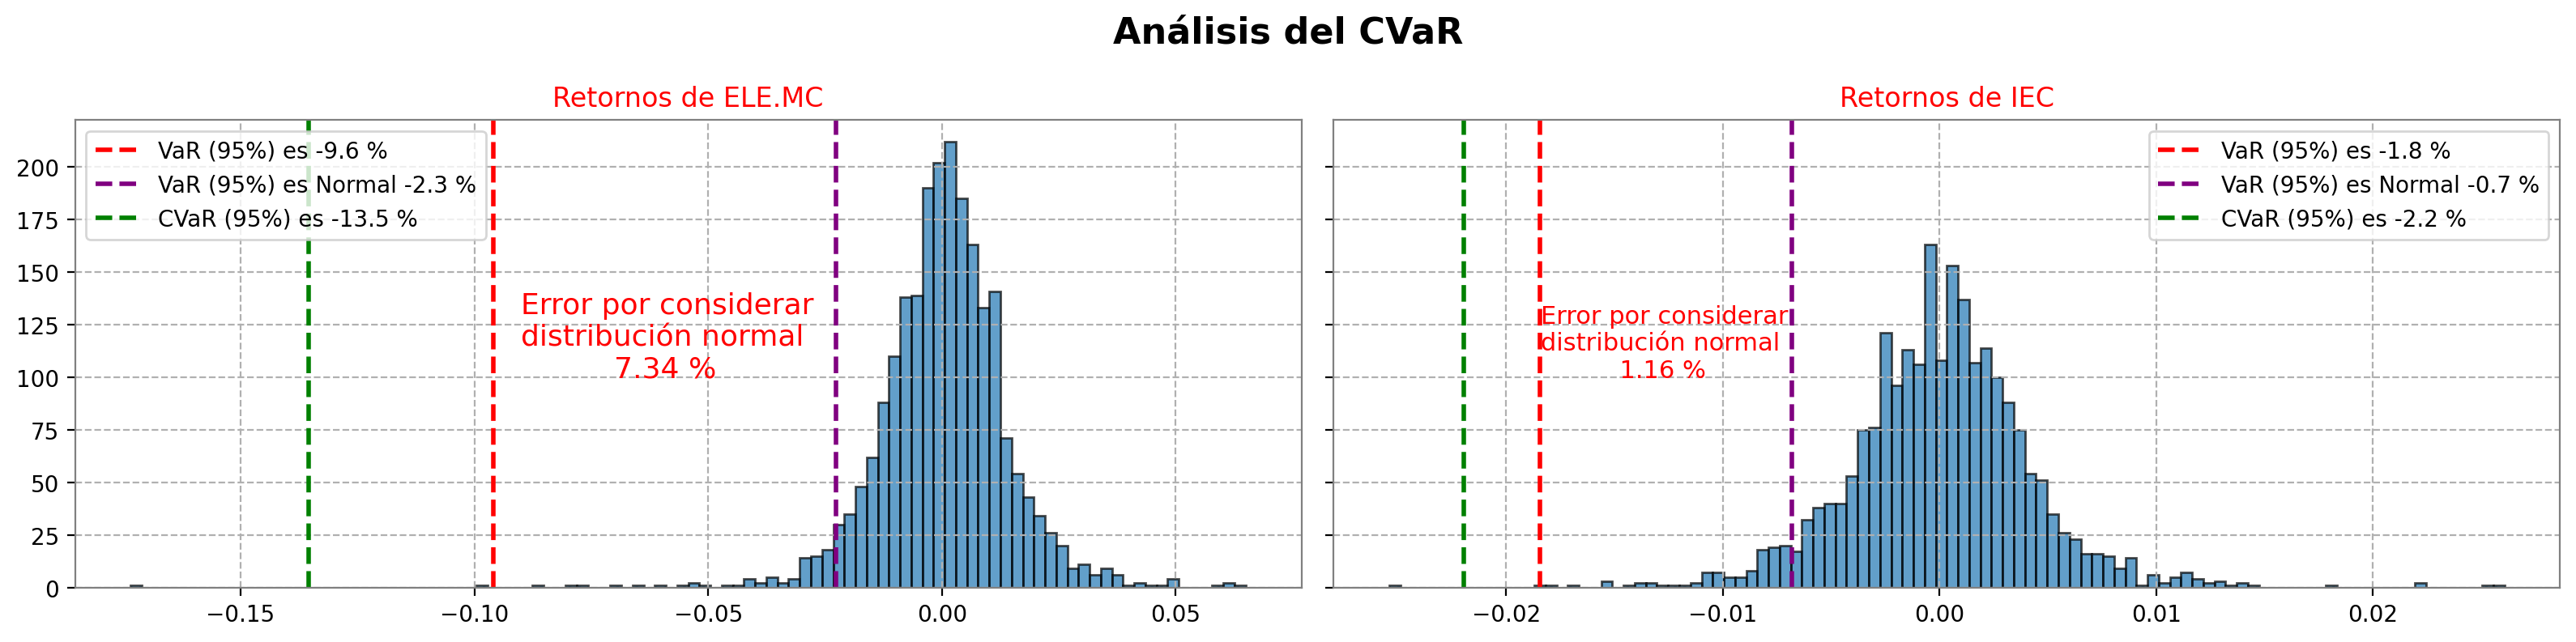

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey='row')
axes[0].hist(ret_close_df['ELE.MC'], bins=100, edgecolor='black', alpha=0.7)
#axes[0].axvline(x=var1_90, color='green', linestyle='--', linewidth=2, label=f'VaR (90%) es {100 * var1_90:.1f} %')
axes[0].axvline(x=var_95_ele, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_ele:.1f} %')
axes[0].axvline(x=varn_95_ele, color='purple', linestyle='--', linewidth=2, label=f'VaR (95%) es Normal {100 * varn_95_ele:.1f} %')
axes[0].text(-0.09, 100, f"Error por considerar\ndistribución normal\n          {100 *np.abs(var_95_ele-varn_95_ele):.2f} %", fontsize=13, color='RED')
axes[0].axvline(x=cvar_95_ele, color='green', linestyle='--', linewidth=2, label=f'CVaR (95%) es {100 * cvar_95_ele:.1f} %')

axes[0].set_ylabel('')
axes[0].set_title('Retornos de ELE.MC')
axes[0].legend()

axes[1].hist(ret_close_df['IEF'], bins=100, edgecolor='black', alpha=0.7)
#axes[1].axvline(x=var2_90, color='green', linestyle='--', linewidth=2, label=f'VaR (90%) es {100 * var2_90:.1f} %')
axes[1].axvline(x=var_95_ief, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_ief:.1f} %')
axes[1].axvline(x=varn_95_ief, color='purple', linestyle='--', linewidth=2, label=f'VaR (95%) es Normal {100 * varn_95_ief:.1f} %')
axes[1].text(-0.0184, 100, f"Error por considerar\ndistribución normal\n          {100 *np.abs(var_95_ief-varn_95_ief):.2f} %", fontsize=11, color='RED')
axes[1].axvline(x=cvar_95_ief, color='green', linestyle='--', linewidth=2, label=f'CVaR (95%) es {100 * cvar_95_ief:.1f} %')

axes[1].set_ylabel('')
axes[1].set_title('Retornos de IEC')
axes[1].legend()


plt.suptitle('Análisis del CVaR', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

### Maximum Drawdown

Max Drawdown es una medida del riesgo en las finanzas que te ayuda a entender cuánto puedes perder en una inversión o cartera en el peor momento antes de que empiece a recuperarse

1. Encuentra el punto más alto: Identifica el valor máximo alcanzado por la inversión hasta un cierto momento.

2. Encuentra el punto más bajo mientras no se supere el máximo: Desde el punto más alto encontrado en el paso 1, busca el valor más bajo que alcanzó la inversión mientras no se haya superado ese máximo. Este valor más bajo representa la mayor caída o drawdown.

3. Calcula el drawdown máximo: Resta el valor más bajo del punto más alto encontrado en el paso 1. El resultado es el drawdown máximo

4. Reinicia el cálculo después de superar el punto más alto: Después de que el valor de la inversión supere el punto más alto anterior (el máximo registrado), comienza un nuevo cálculo de drawdown máximo. Esto significa que cualquier pérdida anterior se considera parte del drawdown pasado, y se inicia un nuevo registro del drawdown a partir del nuevo punto más alto.

El drawdown máximo evoluciona a medida que la inversión alcanza nuevos máximos. 

Veamos cómo calcular el Máximo Drawdown de un activo. Para ello usamos el método de expanding window de pandas

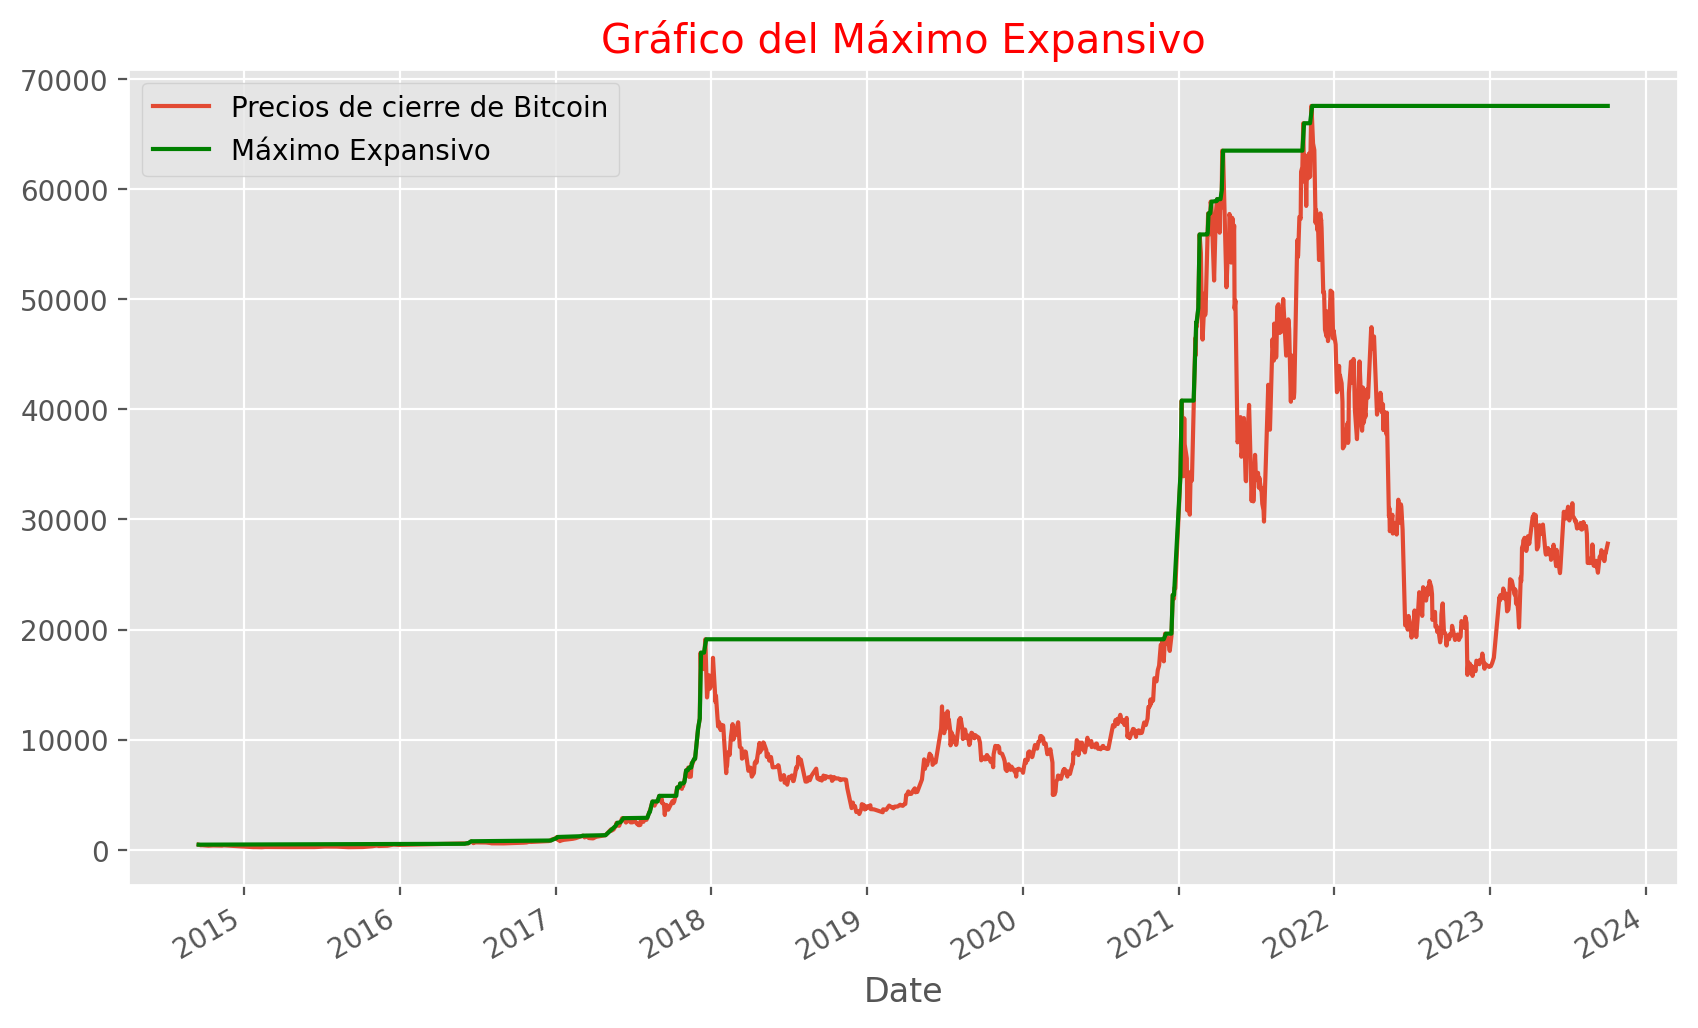

In [145]:
expanding_max = data_close_df["BTC-USD"].expanding().max()

fig, ax = plt.subplots(figsize=(10, 6))

data_close_df["BTC-USD"].plot(label='Precios de cierre de Bitcoin');
expanding_max.plot(label='Máximo Expansivo', color='green');
plt.legend()
plt.title('Gráfico del Máximo Expansivo')
plt.show()

Ahora calculo el drawdown máximo de cada activo. Para ello calculamos $Drawdown = \frac{P_t - P_{max}}{P_{max}} = \frac{P_t}{P_{max}}-1$

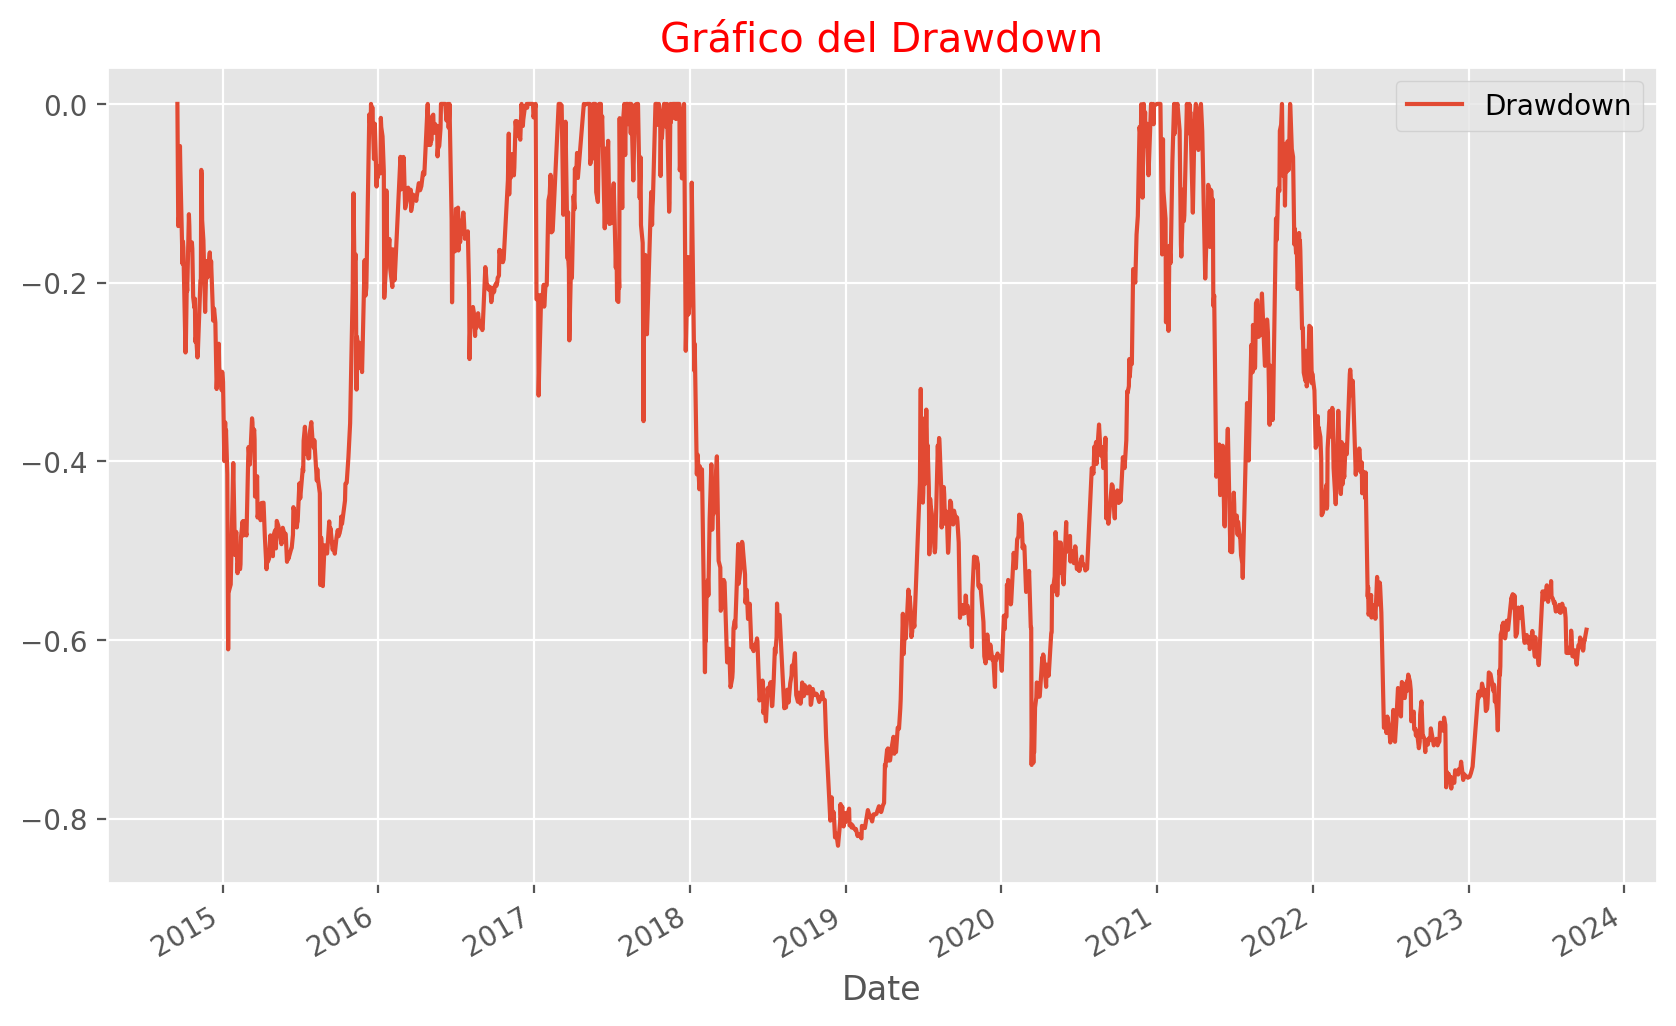

In [146]:
drawdown = (data_close_df["BTC-USD"] / expanding_max)-1
drawdown.plot(label = 'Drawdown', figsize=(10, 6));
plt.legend()
plt.title('Gráfico del Drawdown');

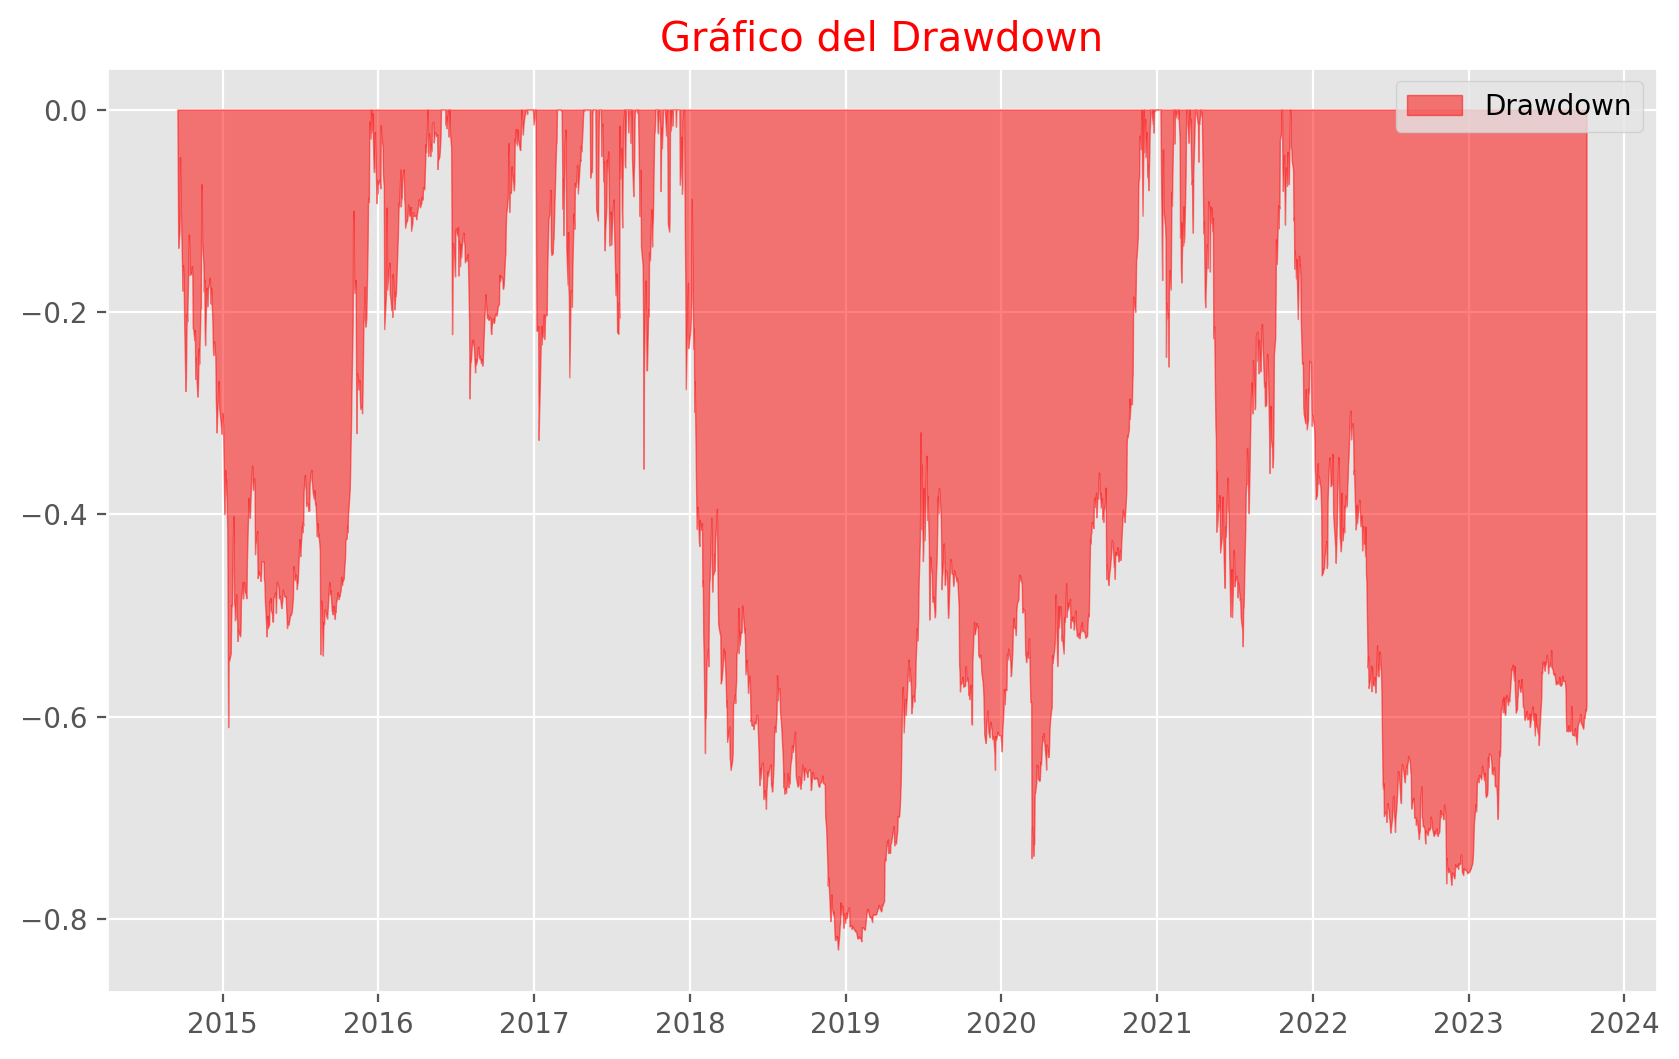

In [149]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.fill_between(data_close_df["BTC-USD"].index.values, drawdown, label='Drawdown', color='red', alpha=0.5);

plt.legend()
plt.title('Gráfico del Drawdown');

Podemos evaluar la duración de los periodos de drawdown

In [92]:
drawdown_per = expanding_max[expanding_max > expanding_max.shift(1)]

primer_valor = data_close_df["BTC-USD"].iloc[0]
primer_idx = data_close_df["BTC-USD"].index[0]

drawdown_per = pd.concat([pd.Series(primer_valor, index=[primer_idx]), drawdown_per])

drawdown_len = drawdown_per.index.to_series().diff().dt.days.shift(-1).fillna(0)


### Distribución t-Student para los retornos

La distribución t-Student es una distribución de probabilidad que se usa para modelar la distribución de los retornos de los activos.

Las características de la distribución t-Student son:

* Tiene forma de campana simétrica, como la distribución normal.

* Tiene **colas más pesadas** que la distribución normal, es decir, hay más probabilidad de que ocurran eventos extremos.

* Tiene un parámetro adicional llamado grados de libertad. Cuantos más grados de libertad, más se parece a una distribución normal.


Veamos cómo se comportan los retornos de un activo con una distribución t-Student a la hora de calcular el VaR. Para ello, seguimos los siguientes pasos:

1. Calculamos los parámetros de la distribución de los retornos del activo: media y desviación estándar.

2. Calculamos el VaR del activo usando el método histórico

3. Calculamos el VaR usando la distribución normal y la t-Student.

4. Graficamos la distribución de los retornos del activo y los VaR calculados.

In [122]:
t_params_btc_auto = stats.t.fit(ret_close_df['BTC-USD'])
vart_95_btc_auto = stats.t.ppf(1 - confianza, *t_params_btc_auto)

In [123]:
confianza = 0.95

mu_btc = ret_close_df['BTC-USD'].mean()
sigma_btc = ret_close_df['BTC-USD'].std()

# Calcular el VaR usando el método histórico
var_95_btc = np.percentile(ret_close_df['BTC-USD'], 1 - confianza)

# Calcular el VaR usando el método de la distribución normal
varn_95_btc = stats.norm.ppf(1 - confianza, mu_btc, sigma_btc)

# Calcular el VaR usando el método de la distribución t-student
libertad_grad = 1 # libertad de grados. Cuántos menos grados, más pesadas las colas
t_params = (libertad_grad, mu_btc, sigma_btc) # parámetros de la distribución t-student
vart_95_btc = stats.t.ppf(1 - confianza, *t_params)

In [121]:
cvar_95_btc = np.mean(ret_close_df['BTC-USD'][ret_close_df['BTC-USD'] < var_95_btc])
cvart_95_btc = np.mean()
cvarn_95

-0.36097850302278367

In [95]:
print(f"VaR t-student (95%) es {100 * vart_95_btc:.1f} %")
print(f"VaR normal (95%) es {100 * varn_95_btc:.1f} %")
print(f"VaR histórico (95%) es {100 * var_95_btc:.1f} %")

VaR t-student (95%) es -6.3 %
VaR normal (95%) es -7.2 %
VaR histórico (95%) es -25.5 %


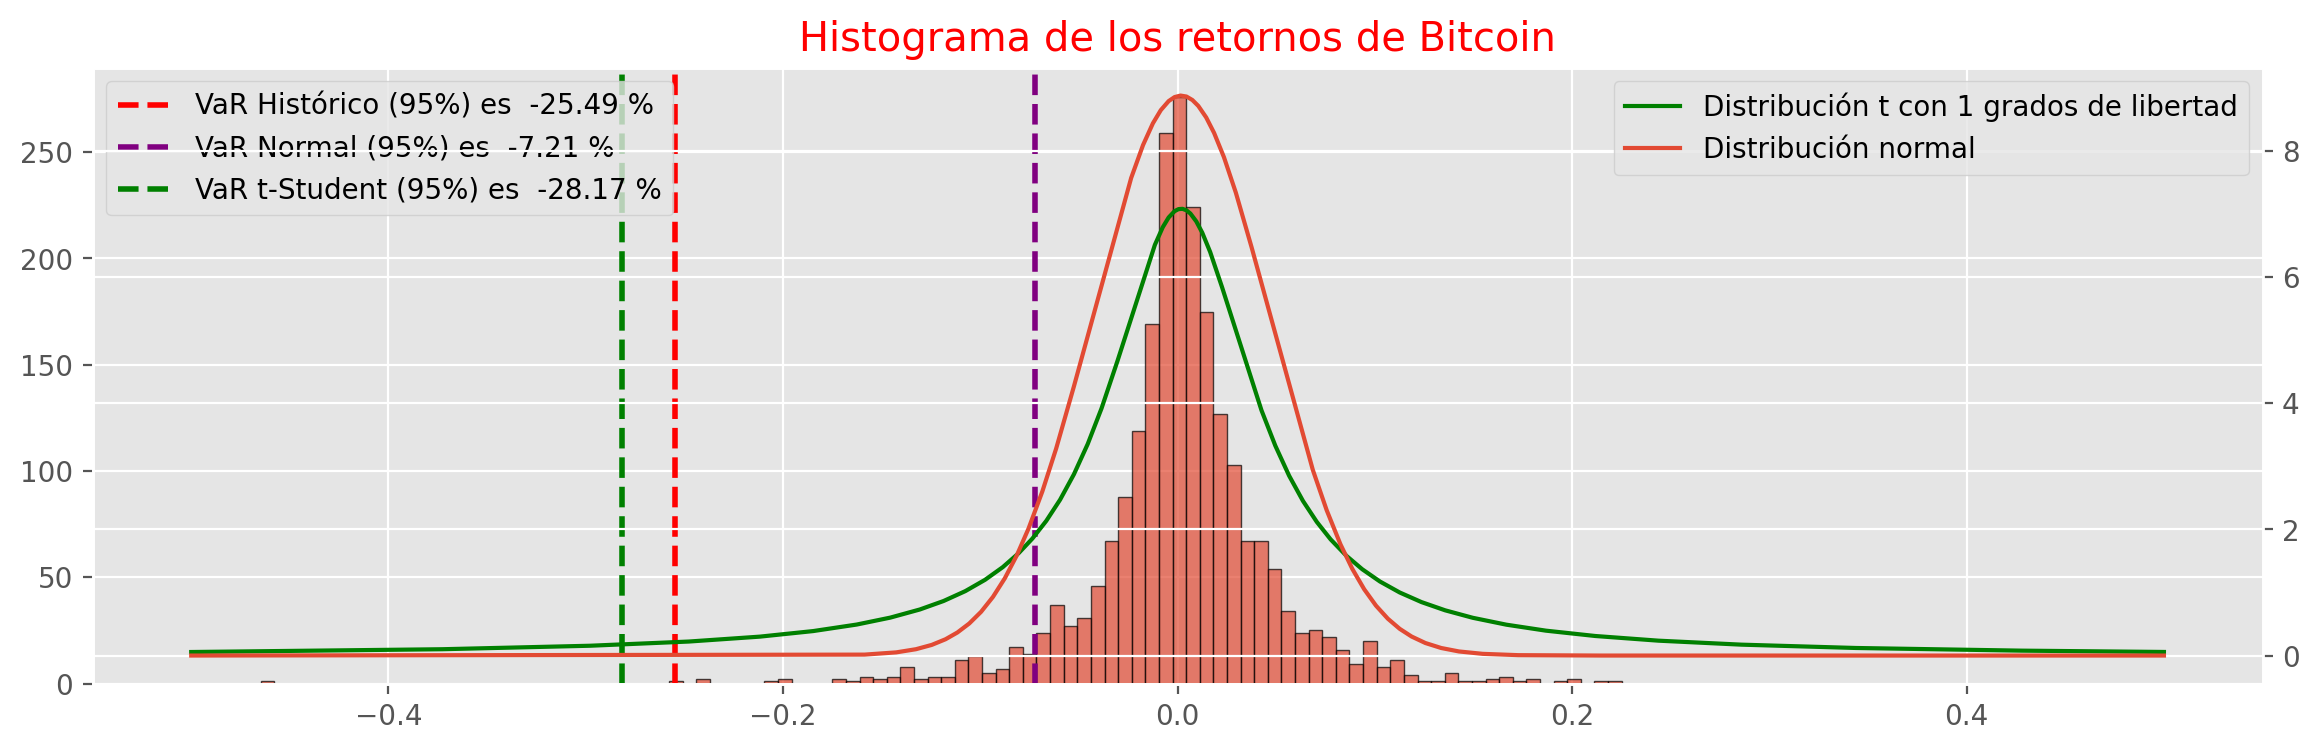

In [156]:
xmin = -0.5
xmax = 0.5
x = np.linspace(xmin, xmax, 1000)

t_pdf = stats.t.pdf(x, *t_params)
n_pdf = stats.norm.pdf(x, mu_btc, sigma_btc)

fig, ax = plt.subplots(figsize=(14, 4))

ax.hist(ret_close_df['BTC-USD'], bins=100, edgecolor='black', alpha=0.7)
plt.title('Histograma de los retornos de Bitcoin');

# Duplicar el eje Y para el segundo gráfico
ax2 = ax.twinx()

ax2.plot(x, t_pdf, color='green', label=f'Distribución t con {libertad_grad} grados de libertad')
ax2.plot(x, n_pdf, label='Distribución normal')
ax2.legend()

ax.axvline(x=var_95_btc, color='red', linestyle='--', linewidth=2, label=f'VaR Histórico (95%) es  {100 * var_95_btc:.2f} %')
ax.axvline(x=varn_95_btc, color='purple', linestyle='--', linewidth=2, label=f'VaR Normal (95%) es  {100 * varn_95_btc:.2f} %')
ax.axvline(x=vart_95_btc, color='green', linestyle='--', linewidth=2, label=f'VaR t-Student (95%) es  {100 * vart_95_btc:.2f} %')
ax.legend(loc='upper left')
#ax.text(-0.016, 80, f"Error por considerar\ndistribución normal\n          {100 * np.abs(var_95_ief-varn_95_ief):.2f} %", fontsize=14, color='RED')

#plt.legend()
